# Utils

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

In [4]:
df = pd.read_csv("ques_and_dis.csv")
df

,relation,nucleus,satellite,question,answer,distractor1,distractor2,distractor3
0,Elaboration,"It is a result of more severe economic problems or a downturn than the recession itself,",which is a slowdown in economic activity over the course of the normal business cycle of growing economy.,What is an economic depression?,Is a slowdown in economic activity over the course of the normal business cycle of growing economy.,Is a period of carried long - term economic downturn that is the result of lowered economic activity in one major or more national economies.,Is a period of carried long - term economic downturn that is the result of lowered economic activity in one major or more national economies.,Is a period of carried long - term economic downturn that is the result of lowered economic activity in one major or more national economies.
1,Elaboration,that may be named economic depression are part of economic cycles,where the slowdown of the economy follows the economic growth and vice versa.,What are the economic cycles?,The slowdown of the economy follows the economic growth and vice versa.,The economy slows down and grows faster.,The economy slows down and grows faster.,The economy slows down and grows faster.


In [2]:
import pickle

def get_tree_dict(pickle_path):
    try: 
        with open(pickle_path, 'rb') as file:
            tree = pickle.load(file)
            return tree
    except:
        print("Can't open file!")

In [3]:
def get_root_id(tree_dict):
    for key, item in tree_dict.items():
        if item['pnode_id'] == -1:
            root_id = key
    return root_id

In [4]:
import treelib

def visualize_rst_tree(tree_dict, root_id, edu_list, new_relation=False, get_edu_text=False):
    rst_tree = treelib.Tree()
    relation_key = 'relation' if not new_relation else 'new_relation'
    node_list = [root_id]

    while node_list:
        id = node_list.pop()
        node = tree_dict[id]
        if (tree_dict.get(node['lnode_id']) is None) and (tree_dict.get(node['rnode_id']) is None):
            node_text = " EDU " + str(node['edu_span'])
            if get_edu_text:
                node_text += ": " + edu_list[node['edu_span'][0] - 1]
            rst_tree.create_node(node_text, id, parent=node['pnode_id'])
        else:
            node_text = node['node_form']

            if node['node_form'] == 'NN':
                node_text += "-" + tree_dict[node['rnode_id']][relation_key]
            elif node['node_form'] == 'NS':
                node_text += "-" + tree_dict[node['rnode_id']][relation_key]
            elif node['node_form'] == 'SN':
                node_text += "-" + tree_dict[node['lnode_id']][relation_key]
            else:
                raise ValueError("Unrecognized N-S form")
            
            if rst_tree.get_node(node['pnode_id']) is not None:
                rst_tree.create_node(node_text, id, parent=node['pnode_id'])
            else:
                rst_tree.create_node(node_text, id)
                print("\nNo parent at node: ", node_text, '\n')

        if tree_dict.get(node['rnode_id']) is not None:
            node_list.append(node['rnode_id'])
        if tree_dict.get(node['lnode_id']) is not None:
            node_list.append(node['lnode_id'])

    return rst_tree

In [5]:
def get_edus_from_file(edu_path):
    """Get EDUs from .edu file and return a list of EDUs
    """
    edus = []
    try: 
        with open(edu_path, 'r') as file:
            for line in file:
                if not line.strip():
                    continue
                edus.append(line.rstrip('\n'))
        return edus    
    except FileNotFoundError:
        print("Error: File not found!")


In [6]:
def extract_segments(edu_list, tree_dict, root_id): # use this when unpickling
    """Extract text segments from (1 or several EDUs) for relation labeller to read from (and make predictions)

    Args:
        edu_list: list containing EDUs (list)
        tree_dict: dict containing tree (dict)

    Return:
        Dict containing text of nucleus, satellite, and original relation from StageDP (dict)
    """

    segments = {'pnode_id': [], 'nucleus': [], 'satellite': [], 'original_relation': []} # if multi-nuclear, satellite represent second nucleus
    node_list = [root_id]
    while node_list:
        id = node_list.pop()
        node = tree_dict[id]

        if (tree_dict.get(node['lnode_id']) is None) and (tree_dict.get(node['rnode_id']) is None): # node is EDU
            continue
    
        left_edu_span = tree_dict[node['lnode_id']]['edu_span'] # tuple: (from, to)
        right_edu_span = tree_dict[node['rnode_id']]['edu_span'] # tuple: (from, to)
        
        # get corresponding text segments
        left_segment = ""
        for edu in range(left_edu_span[0], left_edu_span[1] + 1):
            left_segment += edu_list[edu - 1].strip() + ' '

        right_segment = ""
        for edu in range(right_edu_span[0], right_edu_span[1] + 1):
            right_segment += edu_list[edu - 1].strip() + ' '

        if node['node_form'] == 'NN':
            nucleus = left_segment
            satellite = right_segment
            relation = tree_dict[node['rnode_id']]['relation']
        elif node['node_form'] == 'NS':
            nucleus = left_segment
            satellite = right_segment
            relation = tree_dict[node['rnode_id']]['relation']
        elif node['node_form'] == 'SN':
            nucleus = right_segment
            satellite = left_segment
            relation = tree_dict[node['lnode_id']]['relation']

        segments['nucleus'].append(nucleus)
        segments['satellite'].append(satellite)
        segments['original_relation'].append(relation)
        segments['pnode_id'].append(id)  
        
        if tree_dict.get(node['lnode_id']) is not None:
            node_list.append(node['lnode_id'])
        if tree_dict.get(node['rnode_id']) is not None:
            node_list.append(node['rnode_id'])
    
    return segments

In [7]:
import copy
def add_new_relations_to_tree_dict(tree_dict, new_relations):
    """Extract text segments from (1 or several EDUs) for relation labeller to read from (and make predictions)

    Args:
        tree_dict: dict containing tree (dict)
        new_relations: df containing parent id and new relations (and other components no considered in this method)

    Return:
        New modified tree_dict according to new relations identified
    """
    tree_dict_c = copy.deepcopy(tree_dict)
    for _, r in new_relations.iterrows():
        p_id = r['pnode_id']
        rel = r['new_relation']
        if tree_dict_c[p_id]['node_form'] == 'NN':
            tree_dict_c[tree_dict_c[p_id]['rnode_id']]['new_relation'] = rel
            tree_dict_c[tree_dict_c[p_id]['lnode_id']]['new_relation'] = rel
        elif tree_dict_c[p_id]['node_form'] == 'NS':
            tree_dict_c[tree_dict_c[p_id]['rnode_id']]['new_relation'] = rel
        elif tree_dict_c[p_id]['node_form'] == 'SN':
            tree_dict_c[tree_dict_c[p_id]['lnode_id']]['new_relation'] = rel
        
    return tree_dict_c 

In [8]:
def write_to_text_file(text_path, text):
    """Write string in text to text_path. The text is to be analyzed using RST and generated questions from. 

    Args:
        text_path (str): path of file to write to
        text (str): text to write to (informational text to extract questions from)

    """

    try:
        with open(text_path, 'w') as f:
            f.write(text)
    except:
        print("Can't open text file!\n")

In [9]:
# run this cell to start processing text
# context_path = 'wikipedia_articles/economic_depression.txt'
context_path = '../data/sample/article'
with open(context_path, 'r') as f:
    raw_original_text = f.read()

# remove erronous characters
raw_original_text = raw_original_text.replace(u"\u2018", "'").replace(u"\u2019", "'").replace(u"\u2013", "-").replace(u"\u2014", "-").replace(u"\u201C", "-").replace(u"\u201D", "-") 
text_path = "../data/sample/article"

# write_to_text_file(text_path, raw_original_text)

In [10]:
# run this cell to process new data, adjust paths if necessary

pickle_path = "../data/sample/article.pickle"
edu_path = "../data/sample/article.edus"

tree_dict = get_tree_dict(pickle_path)
root_id = get_root_id(tree_dict)
edus = get_edus_from_file(edu_path)
rst_tree = visualize_rst_tree(tree_dict, root_id, edus, get_edu_text=True)

# print(rst_tree.show(stdout=False, sorting=False)) # uncomment to visualize RST tree
# print(edus)

segments = extract_segments(edus, tree_dict, root_id)
df = pd.DataFrame(segments)
df.shape


No parent at node:  NS-Elaboration 



(10, 4)

In [11]:
# assembly the whole piece of text from EDUs, to ensure allignment

original_text = ""
for edu in edus:
    original_text += edu.strip() + ' '

In [12]:
# map "Comparison" to "Join" since GUM does not contain "Comparison"
for row in df[df['original_relation'] == 'Comparison'].iterrows():
    df.at[row[0], 'original_relation'] = "Joint"

# Relation Labeller

In [13]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = "../models/output_dataset_correct_order_fold_1/checkpoint-23000"
if 'tokenizer' not in locals(): # prevent accidental re-run of cell
    tokenizer = AutoTokenizer.from_pretrained(model_path)

if 'model' not in locals(): # prevent accidental re-run of cell
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(torch.device('cuda'))

/mnt/e/TOM/HUST/20232/question-generation/inference/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Preprocess Data

In [14]:
# get labels
from sklearn.preprocessing import LabelEncoder
label_text = ['Attribution', 'Background', 'Cause', 'Condition', 'Contrast',
       'Elaboration', 'Enablement', 'Evaluation', 'Explanation', 'Joint',
       'Manner-Means', 'Same-Unit', 'Summary', 'Temporal',
       'Textual-Organization', 'Topic-Change', 'Topic-Comment']

label_shorthand = ['Attr', 'Bckg', 'Cause', 'Cond', 'Contst',
       'Elab', 'Enab', 'Eval', 'Expl', 'Joint',
       'Man-Mean', 'Same-Un', 'Sum', 'Temp',
       'Text-Org', 'Top-Chang', 'Top-Com']

le = LabelEncoder()
le.fit(label_text)
labels = le.transform(df.original_relation)

In [15]:
# adding <sep> token between nucleus and satellite
separation_token = "[SEP]"
input_sentences = df.apply(lambda x: ''.join([x['nucleus'], separation_token, x['satellite']]), axis=1)

In [16]:
# merge input sentence and labels onto one list (to form dataset object later)
data = []
for text in input_sentences:
    datapoint = {'text': text}
    data.append(datapoint)
data = np.array(data)

In [17]:
# tokenize
import datasets

def tokenize_function(dataset):
    return tokenizer(dataset["text"], padding=True, truncation=True, return_tensors='pt')

Batch Inference

In [18]:
device = 'cuda'
model.to(device)
model.eval()

batch_size = 32
dataset = datasets.Dataset.from_list(list(data))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

pred_labels = []

with torch.no_grad():
    for batch in dataloader:
        tokens = tokenizer(batch['text'], padding=True, truncation=True, return_tensors='pt').to(device)
        output = model(**tokens)
        logits = torch.Tensor.cpu(output.logits)
        pred_labels.extend(np.argmax(logits, axis=-1).tolist())

In [19]:
preds = le.inverse_transform(pred_labels)
df['new_relation'] = preds

In [20]:
# calculate porportion of changed labels

diff = df.apply(lambda x: x['original_relation'] != x['new_relation'], axis=1)
print(diff.sum(), "changed relations out of", df.shape[0], '(' + str(round(float(diff.sum()/df.shape[0]), 2)) + ')')
# df[diff]

1 changed relations out of 10 (0.1)


In [21]:
# fix old tree with new relations

new_tree_dict = add_new_relations_to_tree_dict(tree_dict, df)
new_rst_tree = visualize_rst_tree(new_tree_dict, get_root_id(new_tree_dict), edus, new_relation=True, get_edu_text=True)

# print(new_rst_tree.show(stdout=False, sorting=False)) # for visualizing rst_tree


No parent at node:  NS-Elaboration 



<BarContainer object of 2 artists>

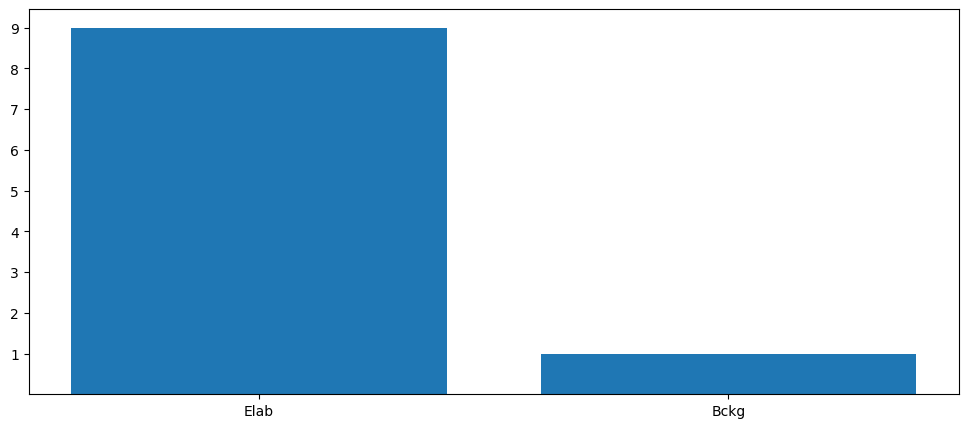

In [22]:
label_cnt = pd.Series(pred_labels).value_counts()
indices = pd.Series(label_shorthand).reindex(label_cnt.index, fill_value=0)

plt.figure(figsize=(12, 5))
plt.yticks(np.arange(1, max(label_cnt) + 1))
plt.bar(indices, label_cnt)

In [23]:
# find occurences of a specific relation

df[df["new_relation"] == "Enablement"]

,pnode_id,nucleus,satellite,original_relation,new_relation


Individual Inference

In [24]:
device = 'cuda'
model.to(device)
model.eval()

sep = tokenizer.sep_token
text_n = "She used the tool in the garden,"
text_s = "so as to win."
text = text_n + sep + text_s

with torch.no_grad():
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)
    output = model(**tokens)
    logits = torch.Tensor.cpu(output.logits)
    single_pred = int(np.argmax(logits, axis=-1))
    
le.inverse_transform([single_pred])[0]

'Enablement'

# Complete Incomplete Questions

In [25]:
MAX_INC_SOURCE_LENGTH = 600
MAX_INC_TARGET_LENGTH = 128
INC_PREFIX = "make question:"

In [26]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

inc_model_path = "../models/t5_base_incomplete_questions_wkdiswfla_max_len_600/not_filter_long_contexts/checkpoint-66000"

if 'inc_tokenizer' not in locals(): # prevent accidental re-run of cell
    inc_tokenizer = T5Tokenizer.from_pretrained(inc_model_path)
if 'inc_model' not in locals(): # prevent accidental re-run of cell
    inc_model = T5ForConditionalGeneration.from_pretrained(inc_model_path)
    inc_model.to('cuda')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [27]:
def complete_question(context, key, answer):
    """Complete question if needed, needs globally available model and tokenizer ("inc_model" and "inc_tokenizer")

    Args:
        context (str): 
        question (str): 
        answer (str): 
    Return:
        str: new question
    """
   
    inc_model.eval()

    inputs = inc_tokenizer(text=f"{INC_PREFIX} answer: {answer}, key: {key}, context: {context}",
                            max_length=MAX_INC_SOURCE_LENGTH,
                            padding='max_length',
                            truncation=True,
                            return_tensors='pt').to('cuda')
            
    output_sequences = inc_model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=MAX_INC_TARGET_LENGTH
    )
    
    output = inc_tokenizer.batch_decode(output_sequences, skip_special_tokens=True)[-1]
    return output

In [28]:
# test run
key = """Why""" 
answer = """The savings & loans and the leveraged buyout crises led to a severe depression in mid - to - late 1989."""

# new_question = complete_question(original_text, key, answer)
# print(f"Keyword: {key}")
# print(f"Question: {new_question}")

BLEU Evaluation

In [29]:
# import pandas as pd
# test_set = pd.read_csv("Datasets/incomplete_questions/final_test_set.csv")

# test_set.shape

In [30]:
# # following the training script: get long questions only
# test_condition = [len(q.split(" ")) >= 10 for q in test_set['question']]
# test_set = test_set[test_condition]

# test_set.shape

In [31]:
def preprocess_testset(dataset):
    prompts = [f"{INC_PREFIX} answer: {answer}, context: {context}, key: {key}" for context, key, answer in zip(dataset['context'], dataset['incomplete_question'], dataset['answer'])]
    desired_output = list(dataset['question'])

    inputs = inc_tokenizer(
        text=prompts,
        max_length=MAX_INC_SOURCE_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    ).to('cuda')

    return inputs # list['input_ids, attention_mask']

In [32]:
def preprocess_testset_with_no_key(dataset):
    prompts = [f"{INC_PREFIX} answer: {answer}, context: {context}, key: " for context, answer in zip(dataset['context'], dataset['answer'])]
    desired_output = list(dataset['question'])

    inputs = inc_tokenizer(
        text=prompts,
        max_length=MAX_INC_SOURCE_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    ).to('cuda')

    return inputs # list['input_ids, attention_mask']

In [33]:
from nltk.translate import bleu_score

def compute_bleu(tokenized_dataset, labels, batch_size):
    """Compute BLEU metric with a tokenized test set. Need to have globally available inc_model and inc_tokenizer

    Args:
        tokenized_dataset (List): containing "input_ids" and "attention_mask" fields
        labels (List[str]): containing reference questions
    """
    inc_model.eval()
    
    data_len = len(tokenized_dataset['input_ids'])
    bleus = []

    for i in range(0, data_len, batch_size):
        output_seqs = inc_model.generate(
            input_ids=tokenized_dataset["input_ids"][i:i+batch_size],
            attention_mask=tokenized_dataset["attention_mask"][i:i+batch_size],
            max_length=MAX_INC_TARGET_LENGTH
        )

        outputs = inc_tokenizer.batch_decode(output_seqs, skip_special_tokens=True)

        bleu = bleu_score.corpus_bleu(list_of_references=[[label] for label in labels[i:i+batch_size]], hypotheses=outputs, weights=(0, 0, 0, 1))
        bleus.append(bleu)
        
    return np.array(bleus).mean()
    

In [34]:
# tokenized_test_set = preprocess_testset(test_set)
# labels = test_set['question']

# bleu_score = compute_bleu(tokenized_test_set, labels, batch_size=5)
# bleu_score

In [35]:
# # bleu score with no key
# tokenized_test_set = preprocess_testset_with_no_key(test_set)
# labels = test_set['question']

# bleu_score = compute_bleu(tokenized_test_set, labels, batch_size=5)
# bleu_score

# Question Generation

Utils

In [36]:
RELATIVE_PRONOUNS = ['who', 'that', 'whose', 'which']

In [37]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_trf')

In [38]:
def get_subj(clause, accept_pron=True, accept_expl=False):
    """Return subject of clause, None of none found

    Args:
        clause (str): 
        accept_expl (bool, optional): If take expletive as subject. Defaults to False.
        accept_expl (bool, optional): If take pronoun as subject. Defaults to True.

    Returns:
        str: The subject
    """
    doc = nlp(clause)

    for token in doc:
        if 'nsubj' in token.dep_:
            if token.pos_ == "PRON" and not accept_pron:
                continue
            for chunk in doc.noun_chunks:
                if chunk.start <= token.i and token.i < chunk.end:
                    return chunk.text
        if accept_expl:
            if 'expl' in token.dep_:
                return token.text
    return None

In [39]:
def get_main_verb(clause):
    """Get main verb of a clause, return None if none found.

    Args:
        clause (str): 
    Returns:
        str:
    """
    doc = nlp(clause)
    root_tok = list(doc.sents)[-1].root

    return root_tok.text

In [40]:
def get_last_noun_chunk(clause):
    """Get last noun chunk of the clause, return None if none found.

    Args:
        clause (str): 
    Returns:
        str:
    """
    doc = nlp(clause)
    if len(list(doc.noun_chunks)) != 0:
        last_noun_chunk = list(doc.noun_chunks)[-1]

        return last_noun_chunk.text
    return None

In [41]:
# WORKING: make a more fool proof method of checking relative clause: inputing both source sents and text, and use pos tags to determine, refer to : is_dependent_clause()
def check_relative_clause(text):
    """Return if the text (has to contain only one clause) is a relative clause, 
    relative clauses can start with "which", "Ving, "Ved" (not including adverbial clause)

    Args:
        text
    Return
        boolean
    """
    doc = nlp(text)

    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if ("nsubj" in token.dep_):
                if (token.text.lower() in RELATIVE_PRONOUNS):
                    return 1 # relative clause starting with relative pronouns
                break

    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if (token.pos_ == "VERB") and (token.tag_ in ['VBG', 'VBN']):
                # WORKING: Change way to check tense, use tag_ instead of morph
                if len(token.morph.get('Tense')) == 0:
                    return 0 # not relative clause
                if token.dep_ == "ROOT" and ((token.text.strip().endswith('ing')) or (token.tag_ == 'VBN')):
                    return 2 # shortened relative clause (starting with Ving or Ved)
            else: 
                return 0

In [42]:
def find_boundary(sent_doc, text_doc):
    """Find boundary indices of text_doc in sent_doc (given that text_doc is in sent_doc)

    Args:
        sent_doc (nlp Doc): 
        text_doc (nlp Doc): 
    """
    start_ind = 0
    while start_ind < len(sent_doc):
        if text_doc.text not in sent_doc[start_ind:].text:
            break
        start_ind += 1
    start_ind -= 1

    end_ind = len(sent_doc)
    while end_ind > 0:
        if (text_doc.text not in sent_doc[:end_ind].text) or (end_ind <= start_ind):
            break
        end_ind -= 1
    end_ind += 1

    return start_ind, end_ind

def is_dependent_clause(src_sent, text):
    # WORKING: may use this way to check relative clause as well
    sent_doc = nlp(src_sent)
    text_doc = nlp(text)   

    start_ind, end_ind = find_boundary(sent_doc, text_doc)
    if start_ind < 0 or end_ind > len(sent_doc):
        print("\nText not found in source sentence!\n")
        return None

    for token in sent_doc[start_ind:end_ind]:
        if token.dep_ in ['acl', 'advcl', 'xcomp']: # omitted "ccomp", put back again if needed
            if token.head.i in range(start_ind, end_ind):
                return False
            return True
    return False     

In [43]:
import inflect
p = inflect.engine()

def unshorten_relative_clause(original_sent, clause):
    """Unshorten relative clause (make sure it's a relative clause before calling this method) ending with Ving or Ved, convert them to which/who + V

    Args:
        clause (str): relative clause containing Ving or Ved
        original_sent (str): original sentence containing that clause
    Return:
        tuple(str, str): modified clause and source sentence
    """

    clause_doc = nlp(clause)
    text_doc = nlp(original_sent)
    vb = ""

    for token in clause_doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if (token.pos_ == "VERB") and (token.tag_ in ['VBG', 'VBN']): # finds Ving or Ved
                vb = token

    for v_token in text_doc:
        # find verb in original sentence
        if v_token.text == vb.text.strip():
            c_i = vb.i
            t_i = v_token.i
            is_verb = True
            while c_i < len(clause_doc) and t_i < len(text_doc):
                if clause_doc[c_i].text.strip() != text_doc[t_i].text.strip():
                    is_verb = False
                    break
                c_i += 1
                t_i += 1
            if is_verb:
                break
    
    pointed_noun = v_token.head
    pointed_noun_chunk = None
    for chunk in text_doc.noun_chunks:
        if chunk.start <= pointed_noun.i and pointed_noun.i < chunk.end:
            pointed_noun_chunk = chunk
    
    if pointed_noun_chunk:
        pointed_root_noun = pointed_noun_chunk.root
    else:
        pointed_root_noun = pointed_noun
    
    rel_pro = "which" 
    # not a fool-proof way to determine if noun is person
    if pointed_root_noun.ent_type_:
        if pointed_root_noun.ent_type_ == "PERSON":
            rel_pro = "who"

    # check plurality of noun/pronoun and conjugate accordingly
    # only applicable for Present Tense, not for past or others
    if pointed_root_noun.pos_.startswith("NOUN"): # noun
        plurality = pointed_root_noun.tag_ == "NNS"
    elif "PRON" in pointed_root_noun.pos_:  # pronoun
        plurality = (pointed_root_noun.lemma_ == "we") or (pointed_root_noun.lemma_ == "you") or (pointed_root_noun.lemma_ == "they") or ((pointed_root_noun.lemma_ == "I"))
    else: # WORKING: for other cases where relative pronoun does not point to a noun, but a verb or a clause
        plurality = False # temporary solution

    if not plurality:
        if vb.tag_ == 'VBG':
            conj_vb = p.plural_noun(vb.lemma_) # get singular conjugation (plural_noun() method works with verbs too)
        else:
            if pointed_root_noun.text.strip() == "I":
                aux = 'am'
            else:
                aux = 'is'
            conj_vb = aux + ' ' + vb.text
    else:
        if vb.tag_ == 'VGB':
            conj_vb = p.plural_verb(vb.lemma_) # get plural conjugation
        else:
            if pointed_root_noun.text.strip() == "I":
                aux = 'am'
            else:
                aux = 'are'
            conj_vb = aux + ' ' + vb.text

    fixed_clause = clause.replace(vb.text, rel_pro + ' ' +  conj_vb, 1)# replace only the first occurence of the verb
    fixed_sent = original_sent.replace(clause.strip(), fixed_clause.strip(), 1)
    return  (fixed_sent, fixed_clause)

In [44]:
unshorten_relative_clause("I saw Tom walking at midnight", "walking at midnight")

('I saw Tom which walks at midnight', 'which walks at midnight')

In [45]:
# WORKING: Need to handle all types of shortened relative clauses, for now, only Ving and Ved is covered.

In [46]:
def is_one_clause(text, count_relative_clause=True):
    """Check if input text is one clause or multiple.
        NOTE: If not multiple clause, the method returns true, so does not account for the case of not a full clause, just check whether multiple clauses or not, cause a EDU is usually at least a clause semantically. 

    Args:
        text (_type_): _description_

    Returns:
        _type_: _description_
    """
    doc = nlp(text)

    # check how many subjects
    has_subj = False
    for token in doc:
        if "nsubj" in token.dep_:
            if not count_relative_clause:
                if token.text.lower() in ['who', 'whom', 'whose', 'which', 'that']:
                    continue
                if token.head.dep_ in ['relcl', 'acl', 'ccomp']:
                    continue
            if has_subj:
                return False
            else:
                has_subj = True
    return True # not return has_subj, so that even no subject will be 1 clause

In [47]:
def is_single_sentence(text):
    """Determine if input text is one single sentence (one main subject and one main verb)

    Args:
        text (str): 

    Returns:
        Boolean: 
    """
    # Parse the input text
    doc = nlp(text)
    
    # Initialize flags for subject and main verb
    subject_count = 0
    verb_count = 0
    
    # Iterate through the tokens in the parsed document
    for token in doc:
        # Check for a subject
        if "nsubj" in token.dep_:
            subject_count += 1
        # Check for the main verb
        if token.pos_ == "VERB" and token.dep_ not in ["pcomp", "relcl", "acl", "ccomp"]:
            verb_count += 1
    
    # Determine if the text is a single clause
    return verb_count == 1 and subject_count == 1

In [48]:
def has_aux(sentence):
    """Check if sentence has auxiliary verb.
    Input one sentence only.
    """
    doc = nlp(sentence)
    for token in doc:
        if "AUX" in token.pos_:
            return True
    return False

In [49]:
auxiliary_shorthand = {
    "'s": "is",
    "'re": "are",
    "'ve": "have",
    "'d": "had",
    "'ll": "will",
    "n't": "not"
}

In [50]:
def move_aux_to_beginning(sentence):
    """Move auxiliary verb to the beginning of sentence (to form question).
    Input one sentence only. Make sure it has aux verb. Make sure sentence starts with subject.
    """
    doc = nlp(sentence)
    aux = ""
    for token in doc:
        if "AUX" in token.pos_:
            aux = token.text
            break
    assert len(aux)

    if aux.strip() in auxiliary_shorthand:
        new_aux = auxiliary_shorthand[aux]
        new_sent = new_aux + ' ' + sentence.strip().replace(aux, '', 1).replace(sentence[0], sentence[0].lower(), 1)
    else:
        new_sent = aux + ' ' + sentence.strip().replace(aux, '', 1).replace(sentence[0], sentence[0].lower(), 1)

    return new_sent

In [51]:
# move aux test run

txt = "The person on the right can be her father, I can do it if not."
if has_aux(txt):
    print(move_aux_to_beginning(txt))

can the person on the right  be her father, I can do it if not.


In [52]:
def has_verb(sentence):
    """Check if sentence has normal verb.
    Input one sentence only.
    """
    doc = nlp(sentence)
    for token in doc:
        if "VERB" in token.pos_:
            return True
    return False

In [53]:
def choose_and_replace_aux_for_verb(sentence):
    """Put appropriate aux at beginnging of clause 
    """
    doc = nlp(sentence)
    main_verb = None

    for token in doc:
        if "VERB" in token.pos_:
            main_verb = token
            break
            
    if not main_verb:
        print("\nCan't find main verb in", sentence, '!\n')
        return ""
    
    # check plurality
    pointed_noun = main_verb.head
    if pointed_noun.pos_.startswith("NOUN"): # noun
        plurality = pointed_noun.tag_ == "NNS"
    elif pointed_noun.pos_.startswith("PRP"):  # pronoun
        plurality = (pointed_noun.lemma_ == "we") or (pointed_noun.lemma_ == "you") or (pointed_noun.lemma_ == "they")
    else: # WORKING: for other cases where relative pronoun does not point to a noun, but a verb or a clause
        plurality = True # temporary solution

    # check tense
    tense = "present" if main_verb.tag_ in ['VBZ', 'VBP'] else 'past'
    # get aux
    aux = {
      "present": "do" if plurality else "does",
      "past": "did",
    }.get(tense)

    # replace appropriate auxilary
    new_sent = sentence.replace(main_verb.text, main_verb.lemma_, 1)
    new_sent = aux + ' ' + new_sent

    return new_sent

In [54]:
# move verb test run

txt = "he hit down."
if has_verb(txt):
    print(choose_and_replace_aux_for_verb(txt))

did he hit down.


In [55]:
def remove_ending_special_chars(sentence):
    """Remove ending non-word characters of a sentence

    Args:
        sentence (str): sentence to be stripped

    Returns:
        str: stripped sentence 
    """
    sen_len = len(sentence)
    for i in range(sen_len - 1, -1, -1):
        char = sentence[i]

        # check if the character is a punctuation mark
        if char.isalnum():
            return sentence
        else:
            sentence = sentence[:i]
    return sentence.strip()

In [56]:
def remove_leading_special_chars(sentence):
    """Remove leading non-word characters of a sentence

    Args:
        sentence (str): sentence to be stripped

    Returns:
        str: stripped sentence 
    """

    start_ind = 0
    for i in range(0, len(sentence)):
        char = sentence[i]
        # check if the character is a punctuation mark
        if char.isalnum():
            break
        else:
            start_ind = i + 1

    return sentence[start_ind: ].strip()

In [57]:
import re
def split_into_sentences(text):
    """Split text into sentence

    Args:
        text (str): text to be splited
    Return: 
        list[str]: split text
    """
    sents = re.split(r"(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)", text)
    sents = [sent for sent in sents if len(sent.strip())]
    return sents

In [58]:
def split_into_paras(text, deli):
    paras = text.split(deli)
    paras = [para.strip() for para in paras if len(para.strip()) != 0]
    return paras

In [59]:
def get_para_id(paras, text):
    """Find paragraph index of text

    Args:
        paras (list[str]): list of paragraphs
        text (str): text to find
    Return:
        int: para id, -1 if not found
    """

    for p_i in range(len(paras)):
        if paras[p_i].find(text.strip()) != -1:
            return p_i
    return -1

In [60]:
def get_subtext(text, key, length):
    """Get subtext of text with length specified surrounding key.\
          0.4 of length will be before the key, 0.6 will be after. 

    Args:
        text (str): 
        length (str): 
    Returns:
        str: the subtext
    """
    bef_len = int(0.4 * length)
    af_len = length - bef_len

    text_words = text.split()
    key_words = key.split()
    
    bef_words = text[:text.find(key)].split()
    pos_bef = len(bef_words)
    pos_af = pos_bef + len(key_words)

    start_ind = 0
    end_ind = len(text_words)

    remainder_start = 0
    remainder_end = 0

    # get start index to extract
    if pos_bef > bef_len:
        start_ind = pos_bef - bef_len
    else:
        start_ind = 0
        remainder_start = bef_len - pos_bef

    # get end index to extract
    if pos_af + af_len <= len(text_words):
        end_ind = pos_af + af_len
    else:
        end_ind = len(text_words)
        remainder_end = pos_af + af_len - len(text_words)

    # if both ends are enough or have remainders
    if (remainder_start != 0 and remainder_end != 0) or (remainder_start == 0 and remainder_end == 0):
        return ' '.join(text_words[start_ind:end_ind])

    # if only one of two ends have remainder
    if remainder_start == 0:
        start_ind = max(0, start_ind - remainder_end)
    if remainder_end == 0:
        end_ind = min(len(text_words), end_ind + remainder_start)

    return ' '.join(text_words[start_ind:end_ind])

In [61]:
import math

def find_source_sents(sents, text, span=2):
    """Find the sentences of which the text is a part. 

    Args:
        sents (str): 
        text (str): 
        span (int): span of sentences to the left to return
    """
    start_ind = 0
    while start_ind < len(sents):
        if text not in ''.join(sents[start_ind:]):
            break
        start_ind += 1
    start_ind -= 1

    end_ind = len(sents) # exclusive
    while end_ind > 0:
        if (text not in ''.join(sents[:end_ind])) or (end_ind <= start_ind):
            break
        end_ind -= 1
    end_ind += 1

    if (start_ind < 0) or (end_ind > len(sents)):
        print(f"\nCan't find source sentences of {text}. Returning the text\n")
        return text
    
    src_sents = ''.join(sents[max(start_ind - span, 0):end_ind])
    return src_sents

In [62]:
def add_subject_to_relative_clause(original_sent, clause):
    """Find and Prepend (with modifications) the subject of relative clause that does not contain one

    Args:
        original_sent (str): sentence from which the clause is extracted
        clause (str): clause for which to find subject
    Return:
        str: subject
    """
    doc = nlp(original_sent)
    subj = ""
    clause_start_ind = original_sent.find(clause)
    for token in doc:
        if (len(subj)):
            break
        if (token.dep_ in ['relcl', 'acl']) and (token.idx >= clause_start_ind) and (token.idx < (clause_start_ind + len(clause))): # relative clause is noun modifier
            for chunk in doc.noun_chunks:
                if token.head.i >= chunk.start and token.head.i < chunk.end:
                    subj = chunk.text
                    break
        
        # WORKING: relative clause is verb/adverb/adjective modifier, not sure if it's necessary tho
        # 'cause adverbial clauses are often in relations that do not require unshortening of clause
        if (token.dep_ in ['advcl', 'ccomp']) and (token.idx >= clause_start_ind) and (token.idx < (clause_start_ind + len(clause))): 
            return None
            # for chunk in doc.noun_chunks:
            #     if token.head.i >= chunk.start and token.head.i < chunk.end:
            #         subj = chunk.text
            #         break
                    
    if not len(subj): # not found subject
        print("\nCan't find subject of", original_sent, "!\n")
        return None         
    
    for token in doc:
        if ("nsubj" in token.dep_) and (token.text.lower() in RELATIVE_PRONOUNS):
            new_clause = clause.replace(token.text, subj) # contains more nuances (where -> in + N, which -> N, who -> N)
            new_sent = original_sent.replace(clause.strip(), new_clause.strip(), 1)
            return new_sent, new_clause

In [63]:
def add_subject_to_fragmented_clause(original_sent, clause):
    """Find and Prepend (with modifications) the subject of a clause that does not contain one, the clause has to contain a verb.

    Args:
        original_sent (str): sentence from which the clause is extracted
        clause (str): clause for which to find subject
    Return:
        str: subject
    """
    doc = nlp(original_sent)
    clause_doc = nlp(clause)
           
    # get main verb of clause
    root_token = None
    for token in clause_doc:
        if "nsubj" in token.dep_:
            return original_sent, clause

        if token.dep_ == "ROOT" and "VERB" in token.pos_:
            root_token = token
            break
    if root_token is None:
        return original_sent, clause
    
    subj = None
    main_verb = None
    clause_start_ind = original_sent.find(clause)
    for token in doc:
        if (token.text == root_token.text) and (token.idx >= clause_start_ind) and (token.idx < (clause_start_ind + len(clause))):
            main_verb = token 
            # token found here is verb of clause, now get verb of the missing part of the clause
            other_verb = token.head
            for c in other_verb.children:
                if "nsubj" in c.dep_:
                    subj = c
                    break
                    
    if subj is None or main_verb is None:
        print(f"\nCan't find subject for {clause}. Return the original clause.\n")
        return original_sent, clause
    
    for chunk in doc.noun_chunks:
        if subj.i >= chunk.start and subj.i < chunk.end:
            subj = chunk
            break
    
    subj = subj.text
    subj_char = list(subj)
    subj_char[0] = subj_char[0].lower()
    subj = ''.join(subj_char)
    
    # get starting point to replace, have main_verb, could be aux before main verb
    for child in main_verb.children:
        if 'aux' in child.dep_:
            main_verb = child
            break
    
    new_clause = clause.replace(main_verb.text, subj + ' ' + main_verb.text)
    new_sent = original_sent.replace(clause.strip(), new_clause.strip(), 1)

    return new_sent, new_clause

In [64]:
# test run
text = "The five factors continued to be supported both conceptually and statistically across major regions of the world,"
# sent = find_source_sents(sents, text, 1)
# add_subject_to_fragmented_clause(sent, text)

In [65]:
def remove_leading_conjunction(original_sent, text):
    """Remove leading conjunctions from text, return intact if cannot find any

    Args:
        original_sent (_type_): _description_
        text (_type_): _description_

    Returns:
        _type_: _description_
    """
    doc = nlp(text)
    
    conj = ""
    for token in doc:
        if token.pos_ in ['PUNCT', 'SYM']:
            continue
        if "CONJ" not in token.pos_:
            return (original_sent, text)
        conj = token.text
        break

    new_text = text.replace(conj.strip(), '', 1)
    new_sent = original_sent.replace(text, new_text)

    return (new_sent, new_text)

In [66]:
def remove_leading_adverb(original_sent, text):
    """Remove leading adverb from text, return intact if cannot find any

    Args:
        original_sent (_type_): _description_
        text (_type_): _description_

    Returns:
        _type_: _description_
    """
    doc = nlp(text)
    if text is None:
        print("This is fucking it: ", original_sent)
    
    for token in doc:
        if token.pos_ in ['PUNCT', 'SYM']:
            continue
        if token.pos_ != 'ADV':
            return (original_sent, text)
        adv = token.text
        break

    new_text = text.replace(adv.strip(), '', 1)
    new_sent = original_sent.replace(text, new_text)

    return (new_sent, new_text)

In [67]:
DISCOURSE_MARKERS = [
  'accordingly', 'additionally', 'afterward', 'also',
  'although', 'as a final point', 'as a result', 'assuming that',
  'besides', 'but also', 'compared to', 'consequently', 'conversely', 'despite',
  'even though', 'finally', 'first', 'firstly', 'for example', 'for instance',
  'for the purpose of', 'furthermore', 'hence', 'however', 'if', 'importantly',
  'in addition', 'in case', 'in conclusion', 'in contrast', 'by contrast', 'in fact',
  'in order to', 'in other words', 'in the event that', 'in the same way',
  'indeed', 'just as', 'lastly', 'likewise', 'moreover', 'namely',
  'nevertheless', 'next', 'nonetheless', 'not only', 'of course', 'on condition that',
  'on the contrary', 'on the one hand', 'on the other hand', 'otherwise', 'plus', 'previously',
  'provided that', 'second', 'secondly', 'similarly', 'similarly to', 'since',
  'so', 'so long as', 'as long as', 'provided that', 'provided', 'so that', 'specifically', 'subsequently',\
  'such as', 'that is to say', 'that is'
  'then', 'therefore', 'third', 'thirdly', 'thus', 'to conclude', 'to illustrate',
  'to put it differently', 'to sum up', 'ultimately', 'undoubtedly', 'unless',
  'while', 'with the aim of', 'yet', 'then', 'and then', 'and'
  'as a consequence', 'as a result', 'in which', "at which", "where", "followed by", "following"
]

In [68]:
import re

def remove_leading_discourse_marker(original_sent, text):
    """Remove leading discourse markers from text, return intact if cannot find any

    Args:
        original_sent (_type_): _description_
        text (_type_): _description_

    Returns:
        _type_: _description_
    """

    discourse_marker = None
    min_pos = len(text)
    for dm in DISCOURSE_MARKERS:
        find_result = text.lower().find(dm)
        if find_result > -1:
            if find_result < min_pos:
                min_pos = find_result
                discourse_marker = dm
            if find_result == min_pos and len(dm) > len(discourse_marker):
                discourse_marker = dm
    
    # check if found marker stand at the beginning of text
        
    if discourse_marker is not None:
        for i in range(0, min_pos):
            if text[i].isalnum() or text[min_pos + len(discourse_marker)].isalnum():
                discourse_marker = None
                break
            
    if not discourse_marker:
        return (original_sent, text)

    pattern = re.compile(discourse_marker, re.IGNORECASE)

    new_text = pattern.sub("", text, 1)
    new_sent = original_sent.replace(text, new_text)
    
    return (new_sent, new_text)

In [69]:
# to be integrated

def replace_substr(text, substring, start_ind, end_ind):
  """Replace part of text with specified index [start_ind, end_ind) with substring
  """
  try:
    assert(len(substring)  == end_ind - start_ind)
  except:
    print('Text:', text, '--', sep='')
    print('Substring:', substring, '--', sep='')

  text_l = list(text)
  text_l[start_ind:end_ind] = list(substring)

  return ''.join(text_l)

In [70]:
def is_in_ref(index, clusters):
    """Check if current index is in one of the references
    
    Args:
        index (int): index to check
        clusters (list(list(tuple))): list of cluster, each cluster containing a list of tuple correponding to indices of the references
    Return:
        tuple (verdict, (start, end), (ref_token_start, ref_token_end)): -1 both index if not found, ref_token is token to relace
    """
    for cluster in clusters:
        for token in cluster:
            if cluster.index(token) == 0:
                continue
            if index >= token[0] and index < token[1]:
                ref_token = (cluster[0][0], cluster[0][1])
                return True, token, ref_token
            
    return False, (-1, -1), (-1, -1)

In [71]:
def check_relative_clause_type(clause):
    """Check which type of relative clause "clause" is: 
    - which + V + clause (present subject is sufficient for being clause)
    - which + V + (not clause)

    Args:
        sent (str): 
        clause (str): 
    Return: 0 or 1, -1 if not relative clause expected (not start with which + V), then it could be an adverbial clause
    """

    doc = nlp(clause.strip())

    i = 0
    while i < len(doc):
        token = doc[i]
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" not in token.pos_: 
                return -1
            else:
                break
        i += 1

    i += 1 
    while i < len(doc):
        token = doc[i]
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "VERB" not in token.pos_ and "AUX" not in token.pos_: 
                return -1        
            else:
                break
        i += 1
    
    # if reach here, is expected relative clause type (which + V)
    i += 1
    t_i = i # use to this to check subject and not modify i
    while t_i < len(doc):
        token = doc[t_i]
        if 'nsubj' in token.dep_:
            return 0
        t_i += 1

    return 1    

In [72]:
# to be integrated
from fastcoref import FCoref, LingMessCoref
if 'coref_resolver' not in locals(): # prevent accidental re-run of cell
    coref_resolver = LingMessCoref(device='cuda:0')

def resolve_coreference(original_sent, text):
    """Perfrom coreference resolution and replace corresponding text.

    Args:
        original_sent (str): Sentence the text was derived froms
        text (str): Target text
    """

    text_ind = original_sent.find(text) # starting index of text in original text
    coref_preds = coref_resolver.predict(texts=[original_sent])
    coref_clusters = coref_preds[0].get_clusters(as_strings=False)
    new_sent = []
    new_text = []

    # interate string left to right while appending current char to a new list
    # if current index in one of the token in one of the clusters, add the replacement to the list, keep the text intact, to know what index are at
    i = 0

    # if referred word is a verb, use have to notice and discard the sentence.
    while i < len(original_sent):
        find_result = is_in_ref(i, coref_clusters)
        if find_result[0]:
            token = find_result[1]
            token_ref = find_result[2]
            new_sent.append(original_sent[token_ref[0]:token_ref[1]])
            if (i >= text_ind and i < text_ind + len(text)):
                if (text_ind <= token[0] and token[1] <= text_ind + len(text)):
                    new_text.append(original_sent[token_ref[0]:token_ref[1]])
                else:
                    new_text.append(original_sent[i:text_ind + len(text)])
            i = token[1]
        else:
            new_sent.append(original_sent[i])
            if i >= text_ind and i < text_ind + len(text):
                new_text.append(original_sent[i])
            i += 1

    return ''.join(new_sent), ''.join(new_text)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 427.2 kB/s eta 0:00:0000:0100:01



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


07/04/2024 00:42:33 - INFO - 	 missing_keys: []
07/04/2024 00:42:33 - INFO - 	 unexpected_keys: []
07/04/2024 00:42:33 - INFO - 	 mismatched_keys: []
07/04/2024 00:42:33 - INFO - 	 error_msgs: []
07/04/2024 00:42:33 - INFO - 	 Model Parameters: 590.0M, Transformer: 434.6M, Coref head: 155.4M


In [73]:
# coref test run    
txt = "Transformers process input sequences in parallel, making the them highly efficient for training and inference"
# sents = split_into_sentences(original_text)
# src = find_source_sents(sents, txt, 5)
# resolve_coreference(src, txt)
coref_preds = coref_resolver.predict(texts=[txt])
coref_clusters = coref_preds[0].get_clusters(as_strings=False)
coref_preds

07/04/2024 00:42:33 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00,  1.85 examples/s]
07/04/2024 00:42:34 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


[CorefResult(text="Transformers process input sequences in parallel, ...", clusters=[['Transformers', 'them']])]

In [74]:
def remove_relative_pronoun(original_sent, text):
    """Remove relative pronouns from text, make sure it's a relative clause first

    Args:
        original_sent (str): 
        text (str): 
    """
    doc = nlp(text)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if ("nsubj" in token.dep_):
                if (token.text.lower() in RELATIVE_PRONOUNS):
                    rel_pro = token.text

    if len(rel_pro) == 0:
        return original_sent, text
    
    new_text = text.replace(rel_pro.strip(), '', 1).strip()
    new_sent = original_sent.replace(text, new_text).strip()
    
    return new_sent, new_text

In [75]:
def preprocessing_pipeline(original_text, text, retain_dm=False, retain_conj=False, retain_adv=False, add_subject_to_rel_clause=False, resolve_coref=False, unshorten_rel=False, remove_rel_pron=True, get_full_sentence=True):
    """Perform necessary transformation steps.

    Args:
        text (str): raw text
    Return:
        (str): full clause from text
    """
    sents = split_into_sentences(original_text)
    text = text.strip()
    
    # coreferen ce resolution
    src_3_sents = find_source_sents(sents, text, 3)
    if resolve_coref:
        src_3_sents, text = resolve_coreference(src_3_sents, text)
    src_sent = find_source_sents(split_into_sentences(src_3_sents), text, 0)

    # if no source sentence found
    if src_sent is None:
        return "", text # system just use text, not original_sent anyway

    # removal of irrelavent components
    if not retain_dm:
        src_sent, text = remove_leading_discourse_marker(src_sent, text)    
    if not retain_conj:
        src_sent, text = remove_leading_conjunction(src_sent, text)
    if not retain_adv: 
        src_sent, text = remove_leading_adverb(src_sent, text)
    src_sent = remove_leading_special_chars(src_sent)
    text = remove_leading_special_chars(text)
    # src_3_sents = remove_ending_special_chars(src_3_sents)
    # text = remove_ending_special_chars(text)

    # handle single relative clause
    if is_one_clause(text, count_relative_clause=False):
        cl_type = check_relative_clause(text)
        if cl_type != 0: # is relative clause
            if cl_type == 2:
                if unshorten_rel:
                    src_sent, text = unshorten_relative_clause(src_sent, text)
            if add_subject_to_rel_clause:
                # WORKING: temporary solution before fixing add_subject_to_relative_clause()
                if add_subject_to_relative_clause(src_sent, text):
                    src_sent, text = add_subject_to_relative_clause(src_sent, text)
            if remove_rel_pron:
                src_sent, text = remove_relative_pronoun(src_sent, text)
        # is not relative clause:
        elif not is_single_sentence(text):
            if get_full_sentence:
                src_sent, text = add_subject_to_fragmented_clause(src_sent, text)

    return src_sent, text  

In [76]:
# preprocessing_pipeline(original_text, "and thus cannot be within the thinking thing.")

In [77]:
import re

def postprocess_question(ques):
    """Clean up the question after being generated.
    Pipeline: Clean double spaces, clean extra punctuations

    Args:
        ques (str): generated question
    Returns:
        str: new question
    """

    puncts_to_remove = ['.', ',', '!']

    ques_c = list(ques)
    for i in range(len(ques_c) - 1, 0, -1):
        if ques_c[i].isalnum():
            break

        if ques_c[i] in puncts_to_remove:
            ques_c.pop(i)
    
    # not adding extra space before question mark, used to have to for the complete question model to run well, but now use only keyword, not incomplete questions anymore
    # for i in range(len(ques_c) - 1, 0, -1):
    #     if ques_c[i] == '?':
    #         ques_c.insert(i, ' ')
    #         break

    new_ques = ''.join(ques_c)
    new_ques = re.sub(r'\s+', ' ', new_ques)
    return new_ques

In [78]:
def postprocess_answer(ans):
    """Clean up the answer after being generated.
    Pipeline: Clean double spaces, clean extra punctuations, capitalize first word.

    Args:
        ans (str): generated answer
    Returns:
        str: new answer
    """

    ending_puncts = ['.', '!']
    ans = ans.strip()
    
    ans_c = list(ans)
    has_punct = False
    for i in range(len(ans_c) - 1, 0, -1):
        if ans_c[i].isalnum():
            break

        if ans_c[i] in ending_puncts:
            if not has_punct:
                has_punct = True
                continue
        ans_c.pop(i)
        
    if not has_punct:
        ans_c.append('.')
        
    for i in range(len(ans_c)):
        if len(ans_c[i].strip()) == 0:
            continue
        ans_c[i] = ans_c[i].upper()
        ans_c = ans_c[i:]
        break

    new_ans = ''.join(ans_c)
    new_ans = re.sub(r'\s+', ' ', new_ans)
    return new_ans

In [79]:
# test run

postprocess_answer("But sometimes humans just literally are not able to do it, to have an algorithm do this:,")

'But sometimes humans just literally are not able to do it, to have an algorithm do this.'

Question Templates

In [80]:
def cause_question_type_0(nucleus, satellite): # WORKING: nucleus cause satellite (but now model interpret both directions, needs fixing)
    """Make question based on CAUSE relationship
    Type 0: satellite (result) is: relative clause: which + verb + clause (e.g. which made him happy.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    # experimenting:exactly the same as type_1
    doc = nlp(satellite)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = satellite.replace(rel_pro.strip(), "What", 1) + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)


def cause_question_type_1(nucleus, satellite):
    """Make question based on CAUSE relationship
    Type 1: satellite (result) is: relative clause: which + verb + (not clause) (e.g. which caused the noise.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    doc = nlp(satellite)
    rel_pro = ""    
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = satellite.replace(rel_pro.strip(), "What", 1) + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)

def cause_question_type_2(nucleus, satellite): 
    """Make question based on CAUSE relationship
    Type 2: satellite (result) is: full clause (not relative clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    if has_aux(satellite):
        new_sate = move_aux_to_beginning(satellite)
    else: 
        new_sate = choose_and_replace_aux_for_verb(satellite)
    question = "Why " + new_sate.strip() + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)

                                             
def generate_cause_question(context, nucleus, satellite, use_template=False):
    """Generate question based on Cause relation. \
        Nucleus being the Cause, which is the answer.

    Args:
        context (str): 
        nucleus (str): 
        satellite (str): 

    Returns:
        Tuple(Boolean, Tuple(str, str)): Boolean dictates if questions are plausible. \
            The second tuple is the question-answer pair. 
    """
    nucleus_pair = preprocessing_pipeline(context, nucleus, 
                                          add_subject_to_rel_clause=False, resolve_coref=False)
    satellite_pair = preprocessing_pipeline(context, satellite, resolve_coref=False)
    # to feed to complete question model for full context
    full_nucleus_pair = preprocessing_pipeline(context, nucleus, resolve_coref=True)
    full_satellite_pair = preprocessing_pipeline(context, satellite, resolve_coref=True)

    # if cannot process one of the two
    if nucleus_pair[1] is None or satellite_pair[1] is None:
        return (False, ("", ""))

    nucleus = nucleus_pair[1]
    satellite = satellite_pair[1]

    # if use template
    if use_template:
        if is_one_clause(satellite, count_relative_clause=False):
            cl_type = check_relative_clause(satellite)
            if cl_type != 0: # is relative clause
                rel_type = check_relative_clause_type(satellite)
                if rel_type == 0:
                    question, answer = cause_question_type_0(nucleus, satellite)
                    return (True, (question, answer))
                elif rel_type == 1:
                    question, answer = cause_question_type_1(nucleus, satellite)
                    return (True, (question, answer))
        else:
            question, answer =  ("", "")
            return (False, (question, answer))
        question, answer =  cause_question_type_2(nucleus, satellite)
        return (True, (question, answer))
   
    # not use template -> use neural question generator
    else:   
        key = "Why"
        last_sate_noun_chunk = get_last_noun_chunk(full_satellite_pair[1])
        if last_sate_noun_chunk is not None:
            key = key + ' ' + last_sate_noun_chunk
       
        answer = nucleus
        question = complete_question(context, key, answer) 
        
        question = postprocess_question(question)
        answer = postprocess_answer(answer)
        return (True, (question, answer))
        

In [81]:
# contrast relation: ask what's different between two subjects.
# retain discourse markers
    
def make_contrast_question_with_two_clauses(nucleus, satellite):
    n_subj = get_subj(nucleus)
    s_subj = get_subj(satellite)
   
    if (n_subj is None) or (s_subj is None):
        print("\nCan't find subject!\n")
        return ("", "")
     
    if n_subj.strip().lower() == s_subj.strip().lower():
        print("\nSame subjects for nucleus and satellite!\n")
        return ("", "")
    
    question = "What is the difference between " + n_subj + " and " + s_subj + '?'
    answer = nucleus.strip() + ' ' + satellite.strip()
    return (question, answer)

def generate_contrast_question(context, nucleus, satellite, use_template=False):
    """Generate question based on Contrast relation.

    Args:
        context (str): 
        nucleus (str): 
        satellite (str): 

    Returns:
        Tuple(Boolean, Tuple(str, str)): Boolean dictates if questions are plausible. \
            The second tuple is the question-answer pair. 
    """
    nucleus_pair = preprocessing_pipeline(context, nucleus, retain_dm=True, 
                                          retain_conj=True, retain_adv=True, 
                                          add_subject_to_rel_clause=True, resolve_coref=False)
    satellite_pair = preprocessing_pipeline(context, satellite, retain_dm=True, 
                                          retain_conj=True, retain_adv=True, 
                                          add_subject_to_rel_clause=False, resolve_coref=False)
    # to feed to complete question model for full context
    full_nucleus_pair = preprocessing_pipeline(context, nucleus, retain_dm=True, 
                                          retain_conj=True, retain_adv=True, 
                                          add_subject_to_rel_clause=True, resolve_coref=True)
    full_satellite_pair = preprocessing_pipeline(context, satellite, retain_dm=True, 
                                          retain_conj=True, retain_adv=True, 
                                          add_subject_to_rel_clause=True, resolve_coref=True)
    # if cannot process one of the two
    if nucleus_pair[1] is None or satellite_pair[1] is None:
        return (False, ("", ""))

    nucleus = nucleus_pair[1]
    satellite = satellite_pair[1]

    # if use template
    if use_template:
        if is_one_clause(nucleus, count_relative_clause=False) and is_one_clause(satellite, count_relative_clause=False):
            ques, ans = make_contrast_question_with_two_clauses(nucleus, satellite)
            return (True, (ques, ans))
        return (False, ("", "")) # more than 1 clause
   
    # not use template -> use neural question generator
    else:   
        # check if subjects are different
        n_subj = get_subj(nucleus)
        s_subj = get_subj(satellite)

        if n_subj and s_subj:
            if (n_subj.strip().lower() == s_subj.strip().lower()):
                return (False, ("", ""))
        
        # currently take full_answer (to feed to complete question model) to be the same as answer, \
        # which is basically the same as original nucleus and satellite, with no context added, \
        # might change later if needed.

        # full_answer = full_nucleus_pair[1].strip() + ' ' + full_satellite_pair[1].strip()
        if context.find(nucleus) < context.find(satellite):           
            full_answer = nucleus.strip() + ' ' + satellite.strip()
            answer = nucleus.strip() + ' ' + satellite.strip()
        else:
            full_answer = satellite.strip() + ' ' + nucleus.strip()
            answer = satellite.strip() + ' ' + nucleus.strip()
        question = complete_question(context, "How different", full_answer)

        question = postprocess_question(question)
        answer = postprocess_answer(answer)
        return (True, (question, answer))


In [82]:
# # test run
sate = "Elves and dwarfs are commonly mentioned and appear to be connected,"
nuc = "but their attributes are vague and the relation between the two is ambiguous."

# generate_contrast_question(original_text, nuc, sate, use_template=False)

In [83]:
# condition relation

def condition_question_type_0(nucleus, satellite): 
    """Make question based on condition relationship
    Type 0: satellite (result) is: relative clause: which + verb + clause (e.g. which made him happy.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    # experimenting:exactly the same as type_1
    doc = nlp(satellite)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = satellite.replace(rel_pro.strip(), "What condition", 1) + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)


def condition_question_type_1(nucleus, satellite):
    """Make question based on condition relationship
    Type 1: satellite (result) is: relative clause: which + verb + (not clause) (e.g. which conditiond the noise.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    doc = nlp(satellite)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = satellite.replace(rel_pro.strip(), "What condition", 1) + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)

def condition_question_type_2(nucleus, satellite): 
    """Make question based on condition relationship
    Type 2: satellite (result) is: full clause (not relative clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    if has_aux(satellite):
        new_sate = move_aux_to_beginning(satellite)
    else: 
        new_sate = choose_and_replace_aux_for_verb(satellite)
    question = "In what condition " + new_sate.strip() + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)

                                             
def generate_condition_question(context, nucleus, satellite, use_template=False):
    """Generate question based on Condition relation.\
    Nucleus is the answer.

    Args:
        context (str): 
        nucleus (str): 
        satellite (str): 

    Returns:
        Tuple(Boolean, Tuple(str, str)): Boolean dictates if questions are plausible. \
            The second tuple is the question-answer pair. 
    """
    nucleus_pair = preprocessing_pipeline(context, nucleus, retain_dm=True, 
                                          retain_conj=True, retain_adv=True, 
                                          add_subject_to_rel_clause=True, resolve_coref=False)
    satellite_pair = preprocessing_pipeline(context, satellite, resolve_coref=True)
    # to feed to complete question model for full context
    full_nucleus_pair = preprocessing_pipeline(context, nucleus, retain_dm=True, 
                                          retain_conj=True, retain_adv=True, 
                                          add_subject_to_rel_clause=True, resolve_coref=True)
    full_satellite_pair = preprocessing_pipeline(context, satellite, retain_dm=True, 
                                          retain_conj=True, retain_adv=True, 
                                          add_subject_to_rel_clause=True, resolve_coref=True)
    # if cannot process one of the two
    if nucleus_pair[1] is None or satellite_pair[1] is None:
        return (False, ("", ""))

    # extract nucleus and satellite
    nucleus = nucleus_pair[1]
    satellite = satellite_pair[1]

    # if use template
    if use_template:
        if is_one_clause(satellite, count_relative_clause=False):
            cl_type = check_relative_clause(satellite)
            if cl_type != 0: # is relative clause
                rel_type = check_relative_clause_type(satellite)
                if rel_type == 0:
                    ques, ans =  condition_question_type_0(nucleus, satellite)
                    return (True, (ques, ans))
                elif rel_type == 1:
                    ques, ans =  condition_question_type_1(nucleus, satellite)
                    return (True, (ques, ans))
            else: # 1 clause, not relative clause 
                ques, ans =  condition_question_type_2(nucleus, satellite)
                return (True, (ques, ans))
        else:
            return (False, ("", ""))
   
    # not use template -> use neural question generator
    else:   
        # currently take full_answer (to feed to complete question model) to be the same as answer, \
        # which is basically the same as original nucleus, with no context added, \
        # might change later if needed.

        # full_answer = full_satellite_pair[1].strip()
        full_answer = satellite.strip()
        
        question = complete_question(context, "Under what condition", full_answer)
        answer = satellite.strip()

        question = postprocess_question(question)
        answer = postprocess_answer(answer)
        return (True, (question, answer))

In [84]:
# test run
sate = "that would not have been remotely economically feasible "
nuc = "if they had to be done by humans"
# generate_condition_question(original_text, nuc, sate)

In [85]:
# enablement relation
# difference to manner-means: enablement encapsulate manner-means, as all means can "enable" the goal,
# but enablement also contains situational aid, an event lead (may not intentionally) to another event
    
# enablement relation

def enablement_question_type_0(nucleus, satellite): 
    """Make question based on enablement relationship
    Type 0: satellite (result) is: relative clause: which + verb + clause (e.g. which made him happy.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    # experimenting: exactly the same as type_1
    doc = nlp(satellite)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = satellite.replace(rel_pro.strip(), "What ", 1) + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)


def enablement_question_type_1(nucleus, satellite):
    """Make question based on enablement relationship
    Type 1: satellite (result) is: relative clause: which + verb + (not clause) (e.g. which enablementd the noise.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    doc = nlp(satellite)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = satellite.replace(rel_pro.strip(), "What ", 1) + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)

def enablement_question_type_2(nucleus, satellite): 
    """Make question based on enablement relationship
    Type 2: satellite (result) is: full clause (not relative clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    if has_aux(satellite):
        new_sate = move_aux_to_beginning(satellite)
    else: 
        new_sate = choose_and_replace_aux_for_verb(satellite)
    question = "How " + new_sate.strip() + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)

def enablement_question_type_3(nucleus, satellite): 
    """Make question based on enablement relationship
    Type 2: satellite (result) is: relative clause but not start with relative pronoun (most probably adverbial clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    question = "What can be done " + satellite.strip() + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)

def generate_enablement_question(context, nucleus, satellite, use_template=False):
    """Generate question based on Enablement relation.\
    Nucleus (the enabler) forms the question. f
    Satellite (the enablee) is the answer.

    Args:
        context (str): 
        nucleus (str): 
        satellite (str): 

    Returns:
        Tuple(Boolean, Tuple(str, str)): Boolean dictates if questions are plausible. \
            The second tuple is the question-answer pair. 
    """
    nucleus_pair = preprocessing_pipeline(context, nucleus, add_subject_to_rel_clause=True, 
                                          resolve_coref=True)
    satellite_pair = preprocessing_pipeline(context, satellite, retain_dm=False, 
                                          retain_conj=True, retain_adv=True, 
                                          add_subject_to_rel_clause=True, resolve_coref=False, unshorten_rel=True, get_full_sentence=False)
    # to feed to complete question model for full context
    full_nucleus_pair = preprocessing_pipeline(context, nucleus, retain_dm=True, 
                                          retain_conj=True, retain_adv=True, 
                                          add_subject_to_rel_clause=True, resolve_coref=True)
    full_satellite_pair = preprocessing_pipeline(context, satellite, retain_dm=True, 
                                          retain_conj=True, retain_adv=True, 
                                          add_subject_to_rel_clause=True, resolve_coref=True)
    # if cannot process one of the two
    if nucleus_pair[1] is None or satellite_pair[1] is None:
        return (False, ("", ""))

    # extract nucleus and satellite
    nucleus = nucleus_pair[1]
    satellite = satellite_pair[1]

    # if use template
    if use_template:
        if is_one_clause(nucleus, count_relative_clause=False):
            cl_type = check_relative_clause(nucleus)
            if cl_type != 0: # is relative clause
                rel_type = check_relative_clause_type(nucleus)
                if rel_type == 0:
                    ques, ans = enablement_question_type_0(nucleus, satellite)
                    return (True, (ques, ans))
                elif rel_type == 1:
                    ques, ans = enablement_question_type_1(nucleus, satellite)
                    return (True, (ques, ans))
            else:
                if is_dependent_clause(nucleus_pair[0], nucleus):
                    ques, ans = enablement_question_type_3(nucleus, satellite)
                    return (True, (ques, ans))
                ques, ans = enablement_question_type_2(nucleus, satellite)
                return (True, (ques, ans))
        return (False, ("", ""))
   
    # not use template -> use neural question generator
    else:   
        # currently take full_answer (to feed to complete question model) to be the same as answer, \
        # which is basically the same as original nucleus, with no context added, \
        # might change later if needed.

        # full_answer = full_nucleus_pair[1].strip()
        last_noun_chunk = get_last_noun_chunk(full_nucleus_pair[1])
        main_verb = get_main_verb(full_nucleus_pair[1])
        key = "For what purpose"

        if last_noun_chunk is not None:
            key = key + ' ' + last_noun_chunk
        # if main_verb is not None:
        #     key = key + ' ' + main_verb

        full_answer = satellite.strip() 
        question = complete_question(context, key, full_answer)
        answer = satellite.strip()

        question = postprocess_question(question)
        answer = postprocess_answer(answer)
        return (True, (question, answer))

In [86]:
# test run
nuc = """She rides to battle"""
sate = "to choose among the slain and brings her chosen to her afterlife field Folkvangr."

# generate_enablement_question(original_text, nuc, sate, use_template=False)

In [87]:
# Manner-Means relation
    
# manner-means relation
# difference to manner-means: manner-means encapsulate manner-means, as all means can "enable" the goal,
# but manner-means also contains situational aid, an event lead (may not intentionally) to another event
    
# manner-means relation

def means_question_type_0(nucleus, satellite): 
    """Make question based on manner-means relationship
    Type 0: satellite (result) is: relative clause: which + verb + clause (e.g. which made him happy.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    # experimenting: exactly the same as type_1
    doc = nlp(nucleus)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = nucleus.replace(rel_pro.strip(), "What method ", 1) + '?'
    answer = satellite.strip() + '.'

    return (question, answer)


def means_question_type_1(nucleus, satellite):
    """Make question based on manner-means relationship
    Type 1: satellite (result) is: relative clause: which + verb + (not clause) (e.g. which caused the noise.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    doc = nlp(nucleus)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = nucleus.replace(rel_pro.strip(), "What method ", 1) + '?'
    answer = satellite.strip() + '.'

    return (question, answer)

def means_question_type_2(nucleus, satellite): 
    """Make question based on manner-means relationship
    Type 2: satellite (result) is: full clause (not relative clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    if has_aux(nucleus):
        new_nuc = move_aux_to_beginning(nucleus)
    else: 
        new_nuc = choose_and_replace_aux_for_verb(nucleus)
    question = "By what method " + new_nuc.strip() + '?'
    answer = satellite.strip() + '.'

    return (question, answer)

def means_question_type_3(nucleus, satellite): 
    """Make question based on manner-means relationship
    Type 2: satellite (result) is: relative clause but not start with relative pronoun (most probably adverbial clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    question = "What strategy can be employed " + nucleus.strip() + '?'
    answer = satellite.strip() + '.'

    return (question, answer)

def generate_means_question(context, nucleus, satellite, use_template=False):
    """Generate question based on Manner-Means relation.\
    Satellite (the means) is the answer. 
    Nucleus (the end) forms the question.

    Args:
        context (str): 
        nucleus (str): 
        satellite (str): 

    Returns:
        Tuple(Boolean, Tuple(str, str)): Boolean dictates if questions are plausible. \
            The second tuple is the question-answer pair. 
    """
    nucleus_pair = preprocessing_pipeline(context, nucleus, add_subject_to_rel_clause=True, 
                                          resolve_coref=True)
    satellite_pair = preprocessing_pipeline(context, satellite, retain_dm=True, 
                                          retain_conj=True, retain_adv=True, 
                                          add_subject_to_rel_clause=False, resolve_coref=False)
    # to feed to complete question model for full context
    full_nucleus_pair = preprocessing_pipeline(context, nucleus, retain_dm=True, 
                                          retain_conj=True, retain_adv=True, 
                                          add_subject_to_rel_clause=True, resolve_coref=True)
    full_satellite_pair = preprocessing_pipeline(context, satellite, retain_dm=True, 
                                          retain_conj=True, retain_adv=True, 
                                          add_subject_to_rel_clause=True, resolve_coref=True)
    # if cannot process one of the two
    if nucleus_pair[1] is None or satellite_pair[1] is None:
        return (False, ("", ""))

    # extract nucleus and satellite
    nucleus = nucleus_pair[1]
    satellite = satellite_pair[1]

    # if use template
    if use_template:
        if is_one_clause(nucleus, count_relative_clause=False):
            cl_type = check_relative_clause(nucleus)
            if cl_type != 0: # is relative clause
                rel_type = check_relative_clause_type(nucleus)
                if rel_type == 0:
                    ques, ans =  means_question_type_0(nucleus, satellite)
                    return (True, (ques, ans))
                elif rel_type == 1:
                    ques, ans =  means_question_type_1(nucleus, satellite)
                    return (True, (ques, ans))
            else:
                if is_dependent_clause(nucleus_pair[0], nucleus):
                    ques, ans =  means_question_type_3(nucleus, satellite)
                    return (True, (ques, ans))
                ques, ans =  means_question_type_2(nucleus, satellite)
                return (True, (ques, ans))
        return (False, ("", ""))
    
    # not use template -> use neural question generator
    else:   
        # currently take full_answer (to feed to complete question model) to be the same as answer, \
        # which is basically the same as original nucleus, with no context added, \
        # might change later if needed.

        # full_answer = full_nucleus_pair[1].strip()
        full_answer = satellite.strip()

        key = "How"
        last_noun_chunk = get_last_noun_chunk(full_nucleus_pair[1])
        if last_noun_chunk is not None:
            key = key + ' ' + last_noun_chunk

        question = complete_question(context, key, full_answer)
        answer = satellite.strip()

        question = postprocess_question(question)
        answer = postprocess_answer(answer)
        return (True, (question, answer))

In [88]:
# test run

nuc = """scholars have identified elements of Germanic mythology reaching as far back as Proto - Indo - European mythology."""
sate = "By way of comparative mythology sand historical linguistics,"
sub_context = get_subtext(original_text, nuc, 500) # get 500 words

# generate_means_question(sub_context, nuc, sate)

In [89]:
def generate_temporal_question(context, nucleus, satellite, use_template=False):
    """Generate a question based on the Temporal relation.
    Satellite (later event) is the answer.
    Nucleus (preceding event) forms the questiom.

    Args:
        context (str): 
        nucleus (str): 
        satellite (str): 
        use_template (bool, optional): Defaults to False.
    """
    nucleus_pair = preprocessing_pipeline(context, nucleus, add_subject_to_rel_clause=True, 
                                          resolve_coref=True)
    satellite_pair = preprocessing_pipeline(context, satellite,
                                            add_subject_to_rel_clause=False, resolve_coref=False)
    # to feed to complete question model for full context
    full_nucleus_pair = preprocessing_pipeline(context, nucleus, retain_dm=True, 
                                          retain_conj=True, retain_adv=True, 
                                          add_subject_to_rel_clause=True, resolve_coref=True)
    full_satellite_pair = preprocessing_pipeline(context, satellite, retain_dm=True, 
                                          retain_conj=True, retain_adv=True, 
                                          add_subject_to_rel_clause=True, resolve_coref=True)
    # if cannot process one of the two
    if nucleus_pair[1] is None or satellite_pair[1] is None:
        return (False, ("", ""))

    # extract nucleus and satellite
    nucleus = nucleus_pair[1]
    satellite = satellite_pair[1]

    # if use template
    if use_template:
       # WORKING: make template for this relation
        return (False, ("", ""))
    # not use template -> use neural question generator
    else:   
        # currently take full_answer (to feed to complete question model) to be the same as answer, \
        # which is basically the same as original nucleus, with no context added, \
        # might change later if needed.

        # full_answer = full_nucleus_pair[1].strip()
        full_answer = satellite.strip()
        
        question = complete_question(context, "After", full_answer)
        answer = satellite.strip()

        question = postprocess_question(question)
        answer = postprocess_answer(answer)
        return (True, (question, answer))

In [90]:
# test run

nuc = "and the world is enveloped in flames,"
sate = "only to be reborn anew."
sub_context = get_subtext(original_text, nuc, 500) # get 500 words

# generate_temporal_question(sub_context, nuc, sate, use_template=False)

In [91]:
def generate_elaboration_question(context, nucleus, satellite, use_template=False):
    """Generate a question based on the Elaboration relation.
    Satellite (additional information) is the answer.
    Nucleus (basic information) forms the questiom.

    Args:
        context (str): 
        nucleus (str): 
        satellite (str): 
        use_template (bool, optional): Defaults to False.
    """
    nucleus_pair = preprocessing_pipeline(context, nucleus, add_subject_to_rel_clause=True, 
                                          resolve_coref=True)
    satellite_pair = preprocessing_pipeline(context, satellite, 
                                            add_subject_to_rel_clause=False, resolve_coref=False)
    # to feed to complete question model for full context
    full_nucleus_pair = preprocessing_pipeline(context, nucleus, retain_dm=True, 
                                          retain_conj=True, retain_adv=True, 
                                          add_subject_to_rel_clause=True, resolve_coref=True)
    full_satellite_pair = preprocessing_pipeline(context, satellite, retain_dm=True, 
                                          retain_conj=True, retain_adv=True, 
                                          add_subject_to_rel_clause=True, resolve_coref=True)
    # if cannot process one of the two
    if nucleus_pair[1] is None or satellite_pair[1] is None:
        return (False, ("", ""))

    # extract nucleus and satellite
    nucleus = nucleus_pair[1]
    satellite = satellite_pair[1]

    # if use template
    if use_template:
       # WORKING: make template for this relation
        return (False, ("", ""))
    # not use template -> use neural question generator
    else:   
        # from observations, answer makes sense the most when is one sentence
        if not is_single_sentence(satellite.strip()):
            return (False, ("",""))
        # currently take full_answer (to feed to complete question model) to be the same as answer, \
        # which is basically the same as original nucleus, with no context added, \
        # might change later if needed.

        # full_answer = full_nucleus_pair[1].strip()
        full_answer = satellite.strip()
        
        key = "What"
        last_noun_chunk = get_last_noun_chunk(full_nucleus_pair[1])
        if last_noun_chunk is not None:
            key = key + ' ' + last_noun_chunk

        question = complete_question(context, key, full_answer) # don't change "What", need to be general like this
        answer = satellite.strip()

        question = postprocess_question(question)
        answer = postprocess_answer(answer)
        return (True, (question, answer))

In [92]:
# test run
nuc = """yet at the price of his future doom. Their father is the powerful god Njoror."""
sate = "Njoror is strongly associated with ships and seafaring, and so also wealth and prosperity."
sub_context = get_subtext(original_text, nuc, 500) # get 500 words

# generate_elaboration_question(sub_context, nuc, sate, use_template=False)

In [93]:
# # test run for Background
# rel = 'Background'
# for trip in df[df['new_relation'] == rel].iterrows():
#     with open(output_path, 'a') as f:
#         f.write("\nRELATION: " + rel + '\n')

#         f.write("\nOriginal nucleus: " + trip[1]['nucleus'] + '\n')
#         f.write("Original satellite: " + trip[1]['satellite'] + '\n')
#         f.write('\n')
        
#         ques, ans = generate_background_question(original_text, trip[1]['nucleus'], trip[1]['satellite'])
#         if not ques.strip() or not ans.strip():
#             continue
        
#         f.write("\nQuestion: " + ques + '\n')
#         f.write("Answer: " + ans + '\n')

# Distractors Generation

In [94]:
MAX_DIS_SOURCE_LENGTH = 600
MAX_DIS_TARGET_LENGTH = 256
PREFIX = "make 3 distractors:"

In [98]:
# import from local dir
from transformers import AutoTokenizer, T5ForConditionalGeneration
dis_model_path = "../models/t5_base_distractors_generation_with_synthesized_dataset_custom_loss_sep_token_max_len_600/checkpoint-24000"

if 'dis_tokenizer' not in locals(): # prevent accidental re-run of cell
    dis_tokenizer = AutoTokenizer.from_pretrained(dis_model_path)
if 'dis_model' not in locals(): # prevent accidental re-run of cell
    dis_model = T5ForConditionalGeneration.from_pretrained(dis_model_path)
    dis_model.to('cuda')

In [99]:
import re
def postprocess_distractor(dis):
    """Post process generated distractors.
    Pipeline: Remove model's tags, remove redundant spaces.

    Args:
        dis (str): generated distractor

    Returns:
        str: cleaned distractor
    """

    new_dis = dis
    special_tags = ['</s>', '<unk>', '<pad>']
    for tag in special_tags:
        new_dis = new_dis.replace(tag, '') 

    new_dis = re.sub(r'\s+', ' ', new_dis)

    new_dis_c = list(new_dis)
    for i in range(len(new_dis_c)):
        if len(new_dis_c[i].strip()) == 0:
            continue
        new_dis_c[i] = new_dis_c[i].upper()
        new_dis_c = new_dis_c[i:]
        break
    return ''.join(new_dis_c)

In [100]:
def generate_3_distractors(context, question, answer):
    """Generate 3 distractors, needs globally available model and tokenizer ("dis_model" and "dis_tokenizer")

    Args:
        context (str): 
        question (str): 
        answer (str): 
    Return:
        Tuple(dis1, dis2, dis3)
    """

    inputs = dis_tokenizer(text=f"{PREFIX} question: {question}, answer: {answer}, context: {context}", 
                        max_length=MAX_DIS_SOURCE_LENGTH,
                        padding='max_length',
                        truncation=True,
                        return_tensors='pt').to('cuda')
    
    output_sequences = dis_model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=MAX_DIS_TARGET_LENGTH)[0]
    
    # find sep tokens, sep tokens separate among distractors
    output_sequences = [token for token in output_sequences if token not in dis_tokenizer.convert_tokens_to_ids(['<pad>', '</s>'])]
    sep_ids = [i for i, v in enumerate(output_sequences) if v == dis_tokenizer.convert_tokens_to_ids(['<sep>'])[0]]
    try:
        assert len(sep_ids) == 2
    except:
        print("Not enough seperation tokens were found!")
        return ("", "", "")
    
    # remove other special tokens
    dis1 = dis_tokenizer.batch_decode([output_sequences[:sep_ids[0]]])[0]
    dis2 = dis_tokenizer.batch_decode([output_sequences[sep_ids[0] + 1:sep_ids[1]]])[0]
    dis3 = dis_tokenizer.batch_decode([output_sequences[sep_ids[1] + 1:]])[0]
    
    return (dis1, dis2, dis3)

In [101]:
# test run

question = """Why do machine learning algorithms perform tasks without explicit instructions?"""
answer = """That can learn from data and generalize to unseen data."""

# generate_3_distractors(original_text, question, answer)

# Combined Generation

In [102]:
LENGTH_UPPER_BOUND = 35
LENGTH_LOWER_BOUND = 2

In [103]:
def generate_cause_question_and_distractors(questions_df, discourse_df):
    """Generate cause question and correponding distractors, and append it to the dataframe.

    Args:
        questions_df (DataFrame):
    """
    rel = "Cause"
    for trip in discourse_df[discourse_df['new_relation'] == rel].iterrows():
        nucleus = trip[1]['nucleus'].strip()
        satellite = trip[1]['satellite'].strip()
       
        if len(nucleus.split()) > LENGTH_UPPER_BOUND or len(satellite.split()) > LENGTH_UPPER_BOUND or len(nucleus.split()) < LENGTH_LOWER_BOUND or len(satellite.split()) < LENGTH_LOWER_BOUND:
            continue

        sub_context = get_subtext(original_text, nucleus, 500) # get 500 words

        flag, (ques, ans) = generate_cause_question(sub_context, nucleus, satellite)
        if not flag:
            continue
        
        # generate distractors
        dis1, dis2, dis3 = generate_3_distractors(sub_context, ques, ans)

        datapoint = {'relation': [rel], 'nucleus': [nucleus], 'satellite': [satellite], 'question': [ques], 'answer': [ans], 'distractor1': [dis1], 'distractor2': [dis2], 'distractor3': [dis3]}
        questions_df = pd.concat([questions_df, pd.DataFrame(datapoint)], ignore_index=True)
    
    if discourse_df[discourse_df['new_relation'] == rel].shape[0] == 0:
        print(f"No nucleus-satellite pair found for relation {rel}\n")
    
    return questions_df

    

In [104]:
def generate_explanation_question_and_distractors(questions_df, discourse_df):
    """Generate explanation question and correponding distractors, and append it to the dataframe.

    Args:
        questions_df (DataFrame):
    """
    rel = "Explanation"
    for trip in discourse_df[discourse_df['new_relation'] == rel].iterrows():
        nucleus = trip[1]['nucleus'].strip()
        satellite = trip[1]['satellite'].strip()
        
        if len(nucleus.split()) > LENGTH_UPPER_BOUND or len(satellite.split()) > LENGTH_UPPER_BOUND or len(nucleus.split()) < LENGTH_LOWER_BOUND or len(satellite.split()) < LENGTH_LOWER_BOUND:
            continue

        sub_context = get_subtext(original_text, nucleus, 500) # get 500 words
        flag, (ques, ans) = generate_cause_question(sub_context, satellite, nucleus)
        if not flag:
            continue
        
        # generate distractors
        dis1, dis2, dis3 = generate_3_distractors(sub_context, ques, ans)

        datapoint = {'relation': [rel], 'nucleus': [nucleus], 'satellite': [satellite], 'question': [ques], 'answer': [ans], 'distractor1': [dis1], 'distractor2': [dis2], 'distractor3': [dis3]}
        questions_df = pd.concat([questions_df, pd.DataFrame(datapoint)], ignore_index=True)
    
    if discourse_df[discourse_df['new_relation'] == rel].shape[0] == 0:
        print(f"No nucleus-satellite pair found for relation {rel}\n")
    return questions_df
    

In [105]:
def generate_contrast_question_and_distractors(questions_df, discourse_df):
    """Generate contrast question and correponding distractors, and append it to the dataframe.

    Args:
        questions_df (DataFrame):
    """
    rel = "Contrast"
    for trip in discourse_df[discourse_df['new_relation'] == rel].iterrows():
        nucleus = trip[1]['nucleus'].strip()
        satellite = trip[1]['satellite'].strip()
        
        if len(nucleus.split()) > LENGTH_UPPER_BOUND or len(satellite.split()) > LENGTH_UPPER_BOUND or len(nucleus.split()) < LENGTH_LOWER_BOUND or len(satellite.split()) < LENGTH_LOWER_BOUND:
            continue

        sub_context = get_subtext(original_text, nucleus, 500) # get 500 words
        flag, (ques, ans) = generate_contrast_question(sub_context, nucleus, satellite)
        if not flag:
            continue
        
        # generate distractors
        dis1, dis2, dis3 = generate_3_distractors(sub_context, ques, ans)

        datapoint = {'relation': [rel], 'nucleus': [nucleus], 'satellite': [satellite], 'question': [ques], 'answer': [ans], 'distractor1': [dis1], 'distractor2': [dis2], 'distractor3': [dis3]}
        questions_df = pd.concat([questions_df, pd.DataFrame(datapoint)], ignore_index=True)
    
    if discourse_df[discourse_df['new_relation'] == rel].shape[0] == 0:
        print(f"No nucleus-satellite pair found for relation {rel}\n")
    return questions_df
    

In [106]:
def generate_condition_question_and_distractors(questions_df, discourse_df):
    """Generate condition question and correponding distractors, and append it to the dataframe.

    Args:
        questions_df (DataFrame):
    """
    rel = "Condition"
    for trip in discourse_df[discourse_df['new_relation'] == rel].iterrows():
        nucleus = trip[1]['nucleus'].strip()
        satellite = trip[1]['satellite'].strip()
        
        if len(nucleus.split()) > LENGTH_UPPER_BOUND or len(satellite.split()) > LENGTH_UPPER_BOUND or len(nucleus.split()) < LENGTH_LOWER_BOUND or len(satellite.split()) < LENGTH_LOWER_BOUND:
            continue

        sub_context = get_subtext(original_text, nucleus, 500) # get 500 words
        flag, (ques, ans) = generate_condition_question(sub_context, nucleus, satellite)
        if not flag:
            continue
        
        # generate distractors
        dis1, dis2, dis3 = generate_3_distractors(sub_context, ques, ans)

        datapoint = {'relation': [rel], 'nucleus': [nucleus], 'satellite': [satellite], 'question': [ques], 'answer': [ans], 'distractor1': [dis1], 'distractor2': [dis2], 'distractor3': [dis3]}
        questions_df = pd.concat([questions_df, pd.DataFrame(datapoint)], ignore_index=True)
    
    if discourse_df[discourse_df['new_relation'] == rel].shape[0] == 0:
        print(f"No nucleus-satellite pair found for relation {rel}\n")
    return questions_df
    

In [107]:
def generate_enablement_question_and_distractors(questions_df, discourse_df):
    """Generate enablement question and correponding distractors, and append it to the dataframe.

    Args:
        questions_df (DataFrame):
    """
    rel = "Enablement"
    for trip in discourse_df[discourse_df['new_relation'] == rel].iterrows():
        nucleus = trip[1]['nucleus'].strip()
        satellite = trip[1]['satellite'].strip()
        
        if len(nucleus.split()) > LENGTH_UPPER_BOUND or len(satellite.split()) > LENGTH_UPPER_BOUND or len(nucleus.split()) < LENGTH_LOWER_BOUND or len(satellite.split()) < LENGTH_LOWER_BOUND:
            continue

        sub_context = get_subtext(original_text, nucleus, 500) # get 500 words
        flag, (ques, ans) = generate_enablement_question(sub_context, nucleus, satellite)
        if not flag:
            continue
        
        # generate distractors
        dis1, dis2, dis3 = generate_3_distractors(sub_context, ques, ans)

        datapoint = {'relation': [rel], 'nucleus': [nucleus], 'satellite': [satellite], 'question': [ques], 'answer': [ans], 'distractor1': [dis1], 'distractor2': [dis2], 'distractor3': [dis3]}
        questions_df = pd.concat([questions_df, pd.DataFrame(datapoint)], ignore_index=True)
    
    if discourse_df[discourse_df['new_relation'] == rel].shape[0] == 0:
        print(f"No nucleus-satellite pair found for relation {rel}\n")
    return questions_df
    

In [108]:
def generate_means_question_and_distractors(questions_df, discourse_df):
    """Generate means question and correponding distractors, and append it to the dataframe.

    Args:
        questions_df (DataFrame):
    """
    rel = "Manner-Means"
    for trip in discourse_df[discourse_df['new_relation'] == rel].iterrows():
        nucleus = trip[1]['nucleus'].strip()
        satellite = trip[1]['satellite'].strip()
        
        if len(nucleus.split()) > LENGTH_UPPER_BOUND or len(satellite.split()) > LENGTH_UPPER_BOUND or len(nucleus.split()) < LENGTH_LOWER_BOUND or len(satellite.split()) < LENGTH_LOWER_BOUND:
            continue

        sub_context = get_subtext(original_text, nucleus, 500) # get 500 words
        flag, (ques, ans) = generate_means_question(sub_context, nucleus, satellite)
        if not flag:
            continue
        
        # generate distractors
        dis1, dis2, dis3 = generate_3_distractors(sub_context, ques, ans)

        datapoint = {'relation': [rel], 'nucleus': [nucleus], 'satellite': [satellite], 'question': [ques], 'answer': [ans], 'distractor1': [dis1], 'distractor2': [dis2], 'distractor3': [dis3]}
        questions_df = pd.concat([questions_df, pd.DataFrame(datapoint)], ignore_index=True)
    
    if discourse_df[discourse_df['new_relation'] == rel].shape[0] == 0:
        print(f"No nucleus-satellite pair found for relation {rel}\n")
    return questions_df
    

In [109]:
def generate_temporal_question_and_distractors(questions_df, discourse_df):
    """Generate temporal question and correponding distractors, and append it to the dataframe.

    Args:
        questions_df (DataFrame):
    """
    rel = "Temporal"
    for trip in discourse_df[discourse_df['new_relation'] == rel].iterrows():
        nucleus = trip[1]['nucleus'].strip()
        satellite = trip[1]['satellite'].strip()
        
        if len(nucleus.split()) > LENGTH_UPPER_BOUND or len(satellite.split()) > LENGTH_UPPER_BOUND or len(nucleus.split()) < LENGTH_LOWER_BOUND or len(satellite.split()) < LENGTH_LOWER_BOUND:
            continue

        sub_context = get_subtext(original_text, nucleus, 500) # get 500 words
        flag, (ques, ans) = generate_temporal_question(sub_context, nucleus, satellite)
        if not flag:
            continue
        
        # generate distractors
        dis1, dis2, dis3 = generate_3_distractors(sub_context, ques, ans)

        datapoint = {'relation': [rel], 'nucleus': [nucleus], 'satellite': [satellite], 'question': [ques], 'answer': [ans], 'distractor1': [dis1], 'distractor2': [dis2], 'distractor3': [dis3]}
        questions_df = pd.concat([questions_df, pd.DataFrame(datapoint)], ignore_index=True)
    
    if discourse_df[discourse_df['new_relation'] == rel].shape[0] == 0:
        print(f"No nucleus-satellite pair found for relation {rel}\n")
    return questions_df
    

In [110]:
def generate_elaboration_question_and_distractors(questions_df, discourse_df):
    """Generate elaboration question and correponding distractors, and append it to the dataframe.

    Args:
        questions_df (DataFrame):
    """
    rel = "Elaboration"
    for trip in discourse_df[discourse_df['new_relation'] == rel].iterrows():
        nucleus = trip[1]['nucleus'].strip()
        satellite = trip[1]['satellite'].strip()
        
        if len(nucleus.split()) > LENGTH_UPPER_BOUND or len(satellite.split()) > LENGTH_UPPER_BOUND or len(nucleus.split()) < LENGTH_LOWER_BOUND or len(satellite.split()) < LENGTH_LOWER_BOUND:
            continue

        sub_context = get_subtext(original_text, nucleus, 500) # get 500 words
        flag, (ques, ans) = generate_elaboration_question(sub_context, nucleus, satellite)
        if not flag:
            continue
        
        # generate distractors
        dis1, dis2, dis3 = generate_3_distractors(sub_context, ques, ans)

        datapoint = {'relation': [rel], 'nucleus': [nucleus], 'satellite': [satellite], 'question': [ques], 'answer': [ans], 'distractor1': [dis1], 'distractor2': [dis2], 'distractor3': [dis3]}
        questions_df = pd.concat([questions_df, pd.DataFrame(datapoint)], ignore_index=True)
    
    if discourse_df[discourse_df['new_relation'] == rel].shape[0] == 0:
        print(f"No nucleus-satellite pair found for relation {rel}\n")
    return questions_df
    

# Inspections

In [111]:
sents = split_into_sentences(original_text) # text split into sentences
paras = split_into_paras(raw_original_text, deli='\n\n')

In [112]:
questions = pd.DataFrame(columns=['relation', 'nucleus', 'satellite', 'question', 'answer', 'distractor1', 'distractor2', 'distractor3'])

In [113]:
# full run of 8 relations: Cause, Explanation, Contrast, Condition, Enablement, 
# Manner-Means, Temporal, Elaboration

questions = generate_cause_question_and_distractors(questions, df)
questions = generate_explanation_question_and_distractors(questions, df)
questions = generate_contrast_question_and_distractors(questions, df)
questions = generate_condition_question_and_distractors(questions, df)
questions = generate_enablement_question_and_distractors(questions, df)
questions = generate_means_question_and_distractors(questions, df)
questions = generate_temporal_question_and_distractors(questions, df)
questions = generate_elaboration_question_and_distractors(questions, df)

07/04/2024 01:22:32 - INFO - 	 Tokenize 1 inputs...


No nucleus-satellite pair found for relation Cause

No nucleus-satellite pair found for relation Explanation

No nucleus-satellite pair found for relation Contrast

No nucleus-satellite pair found for relation Condition

No nucleus-satellite pair found for relation Enablement

No nucleus-satellite pair found for relation Manner-Means

No nucleus-satellite pair found for relation Temporal



Map: 100%|██████████| 1/1 [00:00<00:00, 83.43 examples/s]
07/04/2024 01:22:32 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]
07/04/2024 01:22:33 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 107.64 examples/s]
07/04/2024 01:22:34 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]
07/04/2024 01:22:34 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 96.71 examples/s]
07/04/2024 01:22:34 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]
07/04/2024 01:22:37 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 113.73 examples/s]
07/04/2024 01:22:37 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]
07/04/2024 01:22:38 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 11


Can't find subject for there is some economic crisis. Return the original clause.



07/04/2024 01:22:42 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 129.98 examples/s]
07/04/2024 01:22:42 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]
07/04/2024 01:22:43 - INFO - 	 Tokenize 1 inputs...



Can't find subject for where there is some economic crisis. Return the original clause.



Map: 100%|██████████| 1/1 [00:00<00:00, 121.34 examples/s]
07/04/2024 01:22:43 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]
07/04/2024 01:22:43 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 113.04 examples/s]
07/04/2024 01:22:43 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]
07/04/2024 01:22:44 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 129.55 examples/s]
07/04/2024 01:22:44 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]
07/04/2024 01:22:45 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 145.11 examples/s]
07/04/2024 01:22:45 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]
07/04/2024 01:22:45 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 

In [594]:
article_name = 'economic'
questions_dest_path = "generated_questions/my_model/{article_name}"
questions.to_csv(questions_dest_path, index=False)

In [595]:
# full_questions_file_path = './questions_economic_depression'
# with open(full_questions_file_path, 'w') as f:
#     f.write(f"Context: {original_text}\n")
#     f.write("--------------------\n")

#     for row in questions.iterrows():
#         # f.write("\nNucleus: " + nucleus + '\n')
#         # f.write("Satellite: " + satellite + '\n')

#         f.write("\nRelation: " + row[1]['relation'] + '\n')
#         f.write(f"\nQuestion: {row[1]['question']}")
#         f.write(f"\nAnswer: {row[1]['answer']}")
#         f.write(f"\nDistractor 1: {row[1]['distractor1']}")
#         f.write(f"\nDistractor 2: {row[1]['distractor2']}")
#         f.write(f"\nDistractor 3: {row[1]['distractor3']}\n")

In [114]:
questions

,relation,nucleus,satellite,question,answer,distractor1,distractor2,distractor3
0,Elaboration,"It is a result of more severe economic problems or a downturn than the recession itself,",which is a slowdown in economic activity over the course of the normal business cycle of growing economy.,What is an economic depression?,Is a slowdown in economic activity over the course of the normal business cycle of growing economy.,Is a period of carried long - term economic downturn that is the result of lowered economic activity in one major or more national economies.,Is a period of carried long - term economic downturn that is the result of lowered economic activity in one major or more national economies.,Is a period of carried long - term economic downturn that is the result of lowered economic activity in one major or more national economies.
1,Elaboration,that may be named economic depression are part of economic cycles,where the slowdown of the economy follows the economic growth and vice versa.,What are the economic cycles?,The slowdown of the economy follows the economic growth and vice versa.,The economy slows down and grows faster.,The economy slows down and grows faster.,The economy slows down and grows faster.


# Prompt Generation for Evaluation

In [37]:
def get_avg_ques_len(data):
    lens = []
    for datapoint in data:
        lens.append(len(datapoint.split()))
    
    return np.mean(lens)

In [38]:
def get_avg_dis_len(distractors):
    lens = []
    for datapoint in distractors:
        lens.append(len(datapoint[0].split()))
        lens.append(len(datapoint[1].split()))
        lens.append(len(datapoint[2].split()))
    
    return np.mean(lens)

In [71]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)

topic = "personality"
model = 'MixQG'

question_path = f'generated_questions/{model}/{topic}/questions_and_distractors_{topic}.csv'

questions_df = pd.read_csv(question_path)

# extract questions and answers
questions = questions_df['question']
answers = questions_df['answer']
distractors = list(zip(questions_df['dis1'], questions_df['dis2'], questions_df['dis3'])) # if MixQG, the column is 'dis1' instead of 'distractor1' and vise versa

In [72]:
# stats
len(questions), get_avg_ques_len(questions), get_avg_ques_len(answers), get_avg_dis_len(distractors)

(71, 8.19718309859155, 3.0704225352112675, 3.76056338028169)

In [47]:
def make_question_prompt_for_article(article, questions, answers, task_description, prompt_question, include_context=True):
    """Make evaluation prompt for question generated on the article given. 

    Args:
        article (str): 
        questions (list[str]): 
        answers (list[str]): 
    Returns:
        str: the prompt to input to the evaluator LLM
    """
    prompt = """"""

    for i, (question, answer) in enumerate(list(zip(questions, answers))):
        prompt += (f"Question {i + 1}: {question}, Answer {i + 1}: {answer}\n")
    
    if not include_context:
        prompt = f"""{task_description}\n\n{prompt}\n{prompt_question}"""
    else:
        prompt = f"""{task_description}\n\nContext: {article}\n\n{prompt}\n{prompt_question}"""
    return prompt

In [55]:
def make_distractor_prompt_for_article(article, questions, answers, distractors, task_description, prompt_question, include_context=True):
    """Make evaluation prompt for question generated on the article given. 

    Args:
        article (str): 
        questions (list[str]): 
        answers (list[str]): 
        distractors (list[str]): 
    Returns:
        str: the prompt to input to the evaluator LLM
    """
    prompt = """"""

    for i, (question, answer) in enumerate(list(zip(questions, answers))):
        prompt += (f"Question {i + 1}: {question}, Answer {i + 1}: {answer}, Distractor 1: {distractors[i][0]}, Distractor 2: {distractors[i][1]}, Distractor 3: {distractors[i][2]}\n")
    
    if not include_context:
        prompt = f"""{task_description}\n\n{prompt}\n{prompt_question}"""
    else:
        prompt = f"""{task_description}\n\nContext: {article}\n\n{prompt}\n{prompt_question}"""
    return prompt

# Question Generation Prompts

In [32]:
# for relevance 
output_file_path = f"evaluation_prompt/{model}/{topic}/relevance_prompt_{topic}.txt"

task_description = """The task is to rate the questions below. Below are a piece of context, answers, and corresponding questions based on the information in that context."""

prompt_question = """How relevant are these questions to the context? (on a scale of 1 to 5, with 1 being completely irrelevant to the context). Output your results in the following manner: “Question i: s/5” with i being the question number and s being the score."""

prompt = make_question_prompt_for_article(context, questions, answers, task_description, prompt_question)

with open(output_file_path, 'w') as f:
    f.write(prompt)

In [67]:
# for clarity 
output_file_path = f"evaluation_prompt/{model}/{topic}/clarity_prompt_{topic}.txt"

task_description = """The task is to rate the questions below. Below are a piece of context, answers, and corresponding questions based on the information in that context."""

prompt_question = """A question is understandable when it uses clear and concise language and avoids complex or confusing terms. It should directly address the topic and be structured in a straightforward manner, ensuring that the test-taker can quickly grasp what is being asked without misinterpretation. How understandable are these questions? (on a scale of 1 to 5, where 1 being comfusing and impossible to be understood). Output your results in the following manner: “Question i: s/5” with i being the question number and s being the score."""

prompt = make_question_prompt_for_article(context, questions, answers, task_description, prompt_question)

with open(output_file_path, 'w') as f:
    f.write(prompt)

In [68]:
# for answerability 
output_file_path = f"evaluation_prompt/{model}/{topic}/answerability_prompt_{topic}.txt"

task_description = """The task is to rate the questions below. Below are a piece of context, answers, and corresponding questions based on the information in that context."""

prompt_question = """How answerable are these quesions given information in the context? (on a scale of 1 to 5, where 1 being completely unanswerable given the context). Output your results in the following manner: “Question i: s/5” with i being the question number and s being the score."""

prompt = make_question_prompt_for_article(context, questions, answers, task_description, prompt_question)

with open(output_file_path, 'w') as f:
    f.write(prompt)

In [2]:
# for difficulty 
output_file_path = f"evaluation_prompt/{model}/{topic}/difficulty_prompt_{topic}.txt"

task_description = """The task is to rate the questions below. Below are a piece of context, answers, and corresponding questions based on the information in that context."""

prompt_question = """A difficult question should require a higher level of cognitive ability and reasoning, they should not rely on too trivial factual details. How difficult are the questions? (on a scale of 1 to 5, where 1 are extremely simple questions that requires very low-level cognitive abilities). Output your results in the following manner: “Question i: s/5” with i being the question number and s being the score.

Below are few example questions for each level: 
Easy question: What is the capital city of France? (simple recall of factual information)
Medium question: How can the sun rise and set? (understanding the information rather than just recall)
Difficult question: How can urbanization lead to environmental degradation in developing countries? (require breaking down information, examining parts, and understanding relationships among them)
"""

prompt = make_question_prompt_for_article(context, questions, answers, task_description, prompt_question)

with open(output_file_path, 'w') as f:
    f.write(prompt)

NameError: name 'topic' is not defined

# Distractors Generation Prompt

In [115]:
# for relevance 
output_file_path = f"evaluation_prompt/{model}/{topic}/distractor_incorrectness_prompt_{topic}.txt"

task_description = """The task is to rate the distractors below. Below are a piece of context, questions, answers, and distractors for each question."""

prompt_question = """Evaluate the distractors for their incorrectness. A score of 1 indicates that the distractor is correct or too close to the correct answer, making it ineffective as a distractor. A score of 5 indicates that the distractor is clearly incorrect and does not provide any ambiguity regarding the correct answer. Output your results in the following manner for each question: “Question i: Distractor 1: s_1/5, Distractor 2: s_2/5, Distractor 3: s_3/5” with i being the question number and s_1, s_2, s_3 being the scores for each distractor."""

prompt = make_distractor_prompt_for_article(context, questions, answers, distractors, task_description, prompt_question)

with open(output_file_path, 'w') as f:
    f.write(prompt)

In [116]:
# for clarity 
output_file_path = f"evaluation_prompt/{model}/{topic}/distractor_plausibility_prompt_{topic}.txt"

task_description = """The task is to rate the distractors below. Below are a piece of context, questions, answers, and distractors for each question."""

prompt_question = """Evaluate the plausibility of the distractors. A score of 1 suggests that the distractor is implausible or nonsensical, making it obvious that it is incorrect. A score of 5 indicates that the distractor is highly plausible and could be reasonably considered as the correct answer by someone who is unsure. Output your results in the following manner for each question: “Question i: Distractor 1: s_1/5, Distractor 2: s_2/5, Distractor 3: s_3/5” with i being the question number and s_1, s_2, s_3 being the scores for each distractor."""

prompt = make_distractor_prompt_for_article(context, questions, answers, distractors, task_description, prompt_question)

with open(output_file_path, 'w') as f:
    f.write(prompt)

In [117]:
# for answerability 
output_file_path = f"evaluation_prompt/{model}/{topic}/distractor_readability_prompt_{topic}.txt"

task_description = """The task is to rate the distractors below. Below are a piece of context, questions, answers, and distractors for each question."""

prompt_question = """Evaluate the readability of the distractors. A score of 1 means that the distractor is poorly written, confusing, or difficult to understand. A score of 5 indicates that the distractor is clear, concise, and easy to comprehend. Output your results in the following manner for each question: “Question i: Distractor 1: s_1/5, Distractor 2: s_2/5, Distractor 3: s_3/5” with i being the question number and s_1, s_2, s_3 being the scores for each distractor."""

prompt = make_distractor_prompt_for_article(context, questions, answers, distractors, task_description, prompt_question)

with open(output_file_path, 'w') as f:
    f.write(prompt)

In [145]:
# for difficulty 
output_file_path = f"evaluation_prompt/{model}/{topic}/distractor_diversity_prompt_{topic}.txt"

task_description = """The task is to rate the distractors below. Below are a piece of context, questions, answers, and distractors for each question."""

prompt_question = """Evaluate the diversity of the distractors. A score of 1 signifies that the distractors are too similar to each other or to the correct answer, providing little variety. A score of 5 means that the distractors are diverse, covering a range of different concepts or angles, making the question more challenging. Output your results in the following manner for each question: “Question i: Distractor 1: s_1/5, Distractor 2: s_2/5, Distractor 3: s_3/5” with i being the question number and s_1, s_2, s_3 being the scores for each distractor."""

prompt = make_distractor_prompt_for_article(context, questions, answers, distractors, task_description, prompt_question)

with open(output_file_path, 'w') as f:
    f.write(prompt)